<a href="https://colab.research.google.com/github/gazalssr/HerdNet/blob/main/Base_Herdnet_Finetunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEMO - Training and testing HerdNet on nadir aerial images

## Installations

In [1]:
# Check GPU
!nvidia-smi

Tue Nov  7 21:18:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Install the dependencies
!pip install albumentations>=1.0.3
!pip install fiftyone>=0.14.3
!pip install hydra-core>=1.1.0
!pip install opencv-python>=4.5.1.48
!pip install pandas>=1.2.3
!pip install pillow>=8.2.0
!pip install scikit-image>=0.18.1
!pip install scikit-learn>=1.0.2
!pip install scipy>=1.6.2
!pip install wandb>=0.10.33
!pip install numpy>=1.20.0

In [5]:
# Download and install the code
import sys

!git clone https://github.com/gazalssr/HerdNet.git
#!cd '/content/HerdNet' && python setup.py install
!pip install -e /content/HerdNet
sys.path.append('/content/HerdNet')

Cloning into 'HerdNet'...
remote: Enumerating objects: 391, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 391 (delta 19), reused 23 (delta 14), pack-reused 339
Receiving objects: 100% (391/391), 521.76 KiB | 1.84 MiB/s, done.
Resolving deltas: 100% (230/230), done.
Obtaining file:///content/HerdNet
  Preparing metadata (setup.py) ... done
  Running setup.py develop for animaloc


In [7]:
!wandb login
import wandb
import random


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Create datasets

In [ ]:
# Download some of the data of Delplanque et al. (2021) as an example
!gdown 1z9cg2eQs9Xy32ug_OJcbDXIE6A-pEwQM -O /content/data.zip
!unzip -oq /content/data.zip -d /content

Downloading...
From: https://drive.google.com/uc?id=1z9cg2eQs9Xy32ug_OJcbDXIE6A-pEwQM
To: /content/data.zip
100% 88.5M/88.5M [00:01<00:00, 60.2MB/s]


In [1]:
# Set the seed
from animaloc.utils.seed import set_seed

set_seed(9292)

In [2]:
!python /content/HerdNet/tools/patcher.py -h

usage: patcher [-h] [-csv CSV] [-min MIN] [-all ALL] root height width overlap dest

Cut images into patches

positional arguments:
  root        path to the images directory (str)
  height      height of the patches, in pixels (int)
  width       width of the patches, in pixels (int)
  overlap     overlap between patches, in pixels (int)
  dest        destination path (str)

options:
  -h, --help  show this help message and exit
  -csv CSV    path to a csv file containing annotations (str). Defaults to None
  -min MIN    minimum fraction of area for an annotation to be kept (float). Defautls to 0.1
  -all ALL    set to True to save all patches, not only those containing annotations (bool).
              Defaults to False


In [ ]:
# From bbox to points (no need to do this)
import pandas as pd

train_df = pd.read_csv('/content/data/train.csv')
train_df['x'] = (train_df['x_min'] + train_df['x_max']) / 2
train_df['y'] = (train_df['y_min'] + train_df['y_max']) / 2
train_df = train_df[['images','x','y','labels']]
train_df.to_csv('/content/data/train.csv', index=False)

val_df = pd.read_csv('/content/data/val.csv')
val_df['x'] = (val_df['x_min'] + val_df['x_max']) / 2
val_df['y'] = (val_df['y_min'] + val_df['y_max']) / 2
val_df = val_df[['images','x','y','labels']]
val_df.to_csv('/content/data/val.csv', index=False)

FileNotFoundError: ignored

Number of patches: 399


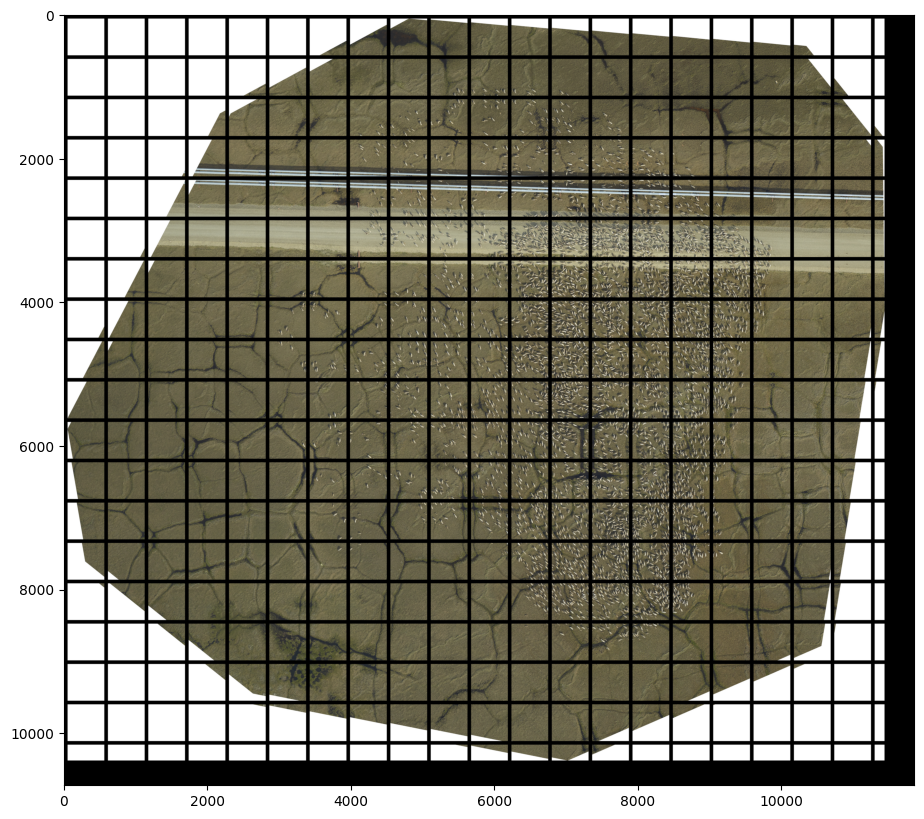

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image as Image

from animaloc.data.patches import ImageToPatches, AnnotatedImageToPatches

img_path = '/content/drive/MyDrive/images/CAH_GRP_1.jpg'

sample_img = Image.open(img_path)

patcher = ImageToPatches(sample_img, (512,512), overlap = 100)
patches = patcher.make_patches()

print(f'Number of patches: {len(patches)}')

plt.figure(figsize=(15,10))
_ = patcher.show()

In [ ]:
# Create training  patches using the patcher tool
from animaloc.utils.useful_funcs import mkdir
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/CAH_small_samples/Train_CAH_Sample/Train_CAH_Sample.csv')
df = df.to_csv('/content/drive/MyDrive/CAH_small_samples/Train_CAH_Sample/Train_CAH_Sample.csv', index=False)
# mkdir('/content/drive/MyDrive/Train_patches')
mkdir('/content/Train_patches') # local directory
# !python /content/HerdNet/tools/patcher.py /content/drive/MyDrive/images/ 512 512 256 /content/Train_patches -csv /content/drive/MyDrive/images/TRAIN_FCH_8.csv -min 0.0 -all True
!python /content/HerdNet/tools/patcher.py /content/drive/MyDrive/CAH_small_samples/Train_CAH_Sample/ 512 512 256 /content/Train_patches -csv /content/drive/MyDrive/CAH_small_samples/Train_CAH_Sample/Train_CAH_Sample.csv -min 0.0 -all False


FileNotFoundError: ignored

In [ ]:
# Create validation patches
#mkdir('/content/drive/MyDrive/val_patches')
mkdir('/content/val_patches')
# !python /content/HerdNet/tools/patcher.py /content/drive/MyDrive/valFCH/ 512 512 256 /content/validation_patches -csv /content/drive/MyDrive/valFCH/FCH_val_8.csv -min 0.0 -all True
!python /content/HerdNet/tools/patcher.py /content/drive/MyDrive/CAH_small_samples/Val_CAH_Sample/ 512 512 256 /content/val_patches -csv /content/drive/MyDrive/CAH_small_samples/Val_CAH_Sample/VAL_CAH_Sample.csv -min 0.0 -all False

Creating the buffer: 100% 2/2 [00:13<00:00,  6.98s/it]
Traceback (most recent call last):
  File "/content/HerdNet/tools/patcher.py", line 92, in <module>
    main()
  File "/content/HerdNet/tools/patcher.py", line 58, in main
    patches_buffer.drop(columns='limits').to_csv(os.path.join(args.dest, 'gt.csv'), index=False)
  File "/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py", line 331, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py", line 5399, in drop
    return super().drop(
  File "/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py", line 331, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py", line 4505, in drop
    obj = obj._drop_axis(labels, axis, level=level, errors=errors)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py", line 4546, in _drop_axis
    new_axis = axis.drop(labels, errors=er

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create test patches
from animaloc.utils.useful_funcs import mkdir
import pandas as pd
mkdir('/content/drive/MyDrive/test_patches')
# mkdir('/content/test_patches')
# !python /content/HerdNet/tools/patcher.py /content/drive/MyDrive/CAH_training_session_1/TestCAH 512 512 256 /content/drive/MyDrive/test_patches -csv /content/drive/MyDrive/CAH_training_session_1/TestCAH/TestCAH_2017_1.csv -min 0.0 -all True
!python /content/HerdNet/tools/patcher.py /content/drive/MyDrive/CAH_small_samples/Test_CAH_Sample/ 512 512 256 /content/test_patches -csv /content/drive/MyDrive/CAH_small_samples/Test_CAH_Sample/Test_CAH_Sample.csv -min 0.0 -all False

Creating the buffer: 100% 2/2 [00:06<00:00,  3.29s/it]
Exporting patches: 100% 8/8 [02:35<00:00, 19.46s/it]


Ziping the patches and transfer to google drive

In [3]:
#make a zip file from the patch folders (Only run this when ypou add a new dataset)
#Zip file path (destination)       source file path
import shutil
shutil.make_archive('/content/drive/MyDrive/Train_patches_S', 'zip', '/content/drive/MyDrive/Train_patches')
shutil.make_archive('/content/drive/MyDrive/val_patches_S', 'zip', '/content/drive/MyDrive/val_patches')
shutil.make_archive('/content/drive/MyDrive/test_patches_S', 'zip', '/content/drive/MyDrive/test_patches')

KeyboardInterrupt: ignored

In [4]:
#### Downloading and unziping the files
#zip file download (destination link)                  Zip file saving location (same as the link)
!gdown https://drive.google.com/uc?id=1-QF9YQHWrlfFxeQcRWYhU0cljm4CvoVz -O /content/Train_patches_S.zip
#Zip file location           uzipped file saving location
!unzip -oq /content/Train_patches_S.zip -d /content/Train_patches

!gdown https://drive.google.com/uc?id=18OfeLVDbgGFAeo09LAd8zMyD16kTLAQ0 -O /content/Val_patches_S.zip
!unzip -oq /content/Val_patches_S.zip -d /content/val_patches

!gdown https://drive.google.com/uc?id=1-79l91SDG5nCiohdvhbIzar3Zab_r60e -O /content/test_patches_S.zip
!unzip -oq /content/test_patches_S.zip -d /content/test_patches


Downloading...
From: https://drive.google.com/uc?id=1-QF9YQHWrlfFxeQcRWYhU0cljm4CvoVz
To: /content/Train_patches_S.zip
100% 200M/200M [00:01<00:00, 133MB/s]
Downloading...
From: https://drive.google.com/uc?id=18OfeLVDbgGFAeo09LAd8zMyD16kTLAQ0
To: /content/Val_patches_S.zip
100% 426M/426M [00:02<00:00, 162MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-79l91SDG5nCiohdvhbIzar3Zab_r60e
To: /content/test_patches_S.zip
100% 415M/415M [00:02<00:00, 168MB/s]


2
5
3
6
25
100
3
3


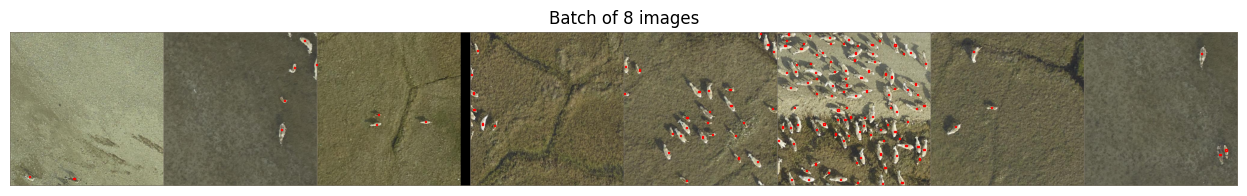

In [8]:
%matplotlib inline
# Showing some samples of patches and the annotations
import matplotlib.pyplot as plt
from animaloc.datasets import CSVDataset
from animaloc.data.batch_utils import show_batch, collate_fn
from torch.utils.data import DataLoader
import torch
import albumentations as A
batch_size = 8

csv_path = '/content/Train_patches/gt.csv'
image_path = '/content/Train_patches'
dataset = CSVDataset(csv_path, image_path, [A.Normalize()])
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

sample_batch = next(iter(dataloader))
for i in range(len(sample_batch[1])):
  points = sample_batch[1][i]['points'].numpy()
  bbox= []
  for pt in points:
      bbox.append([pt[0]-2,pt[1]-2,pt[0]+2,pt[1]+2])
  print(len(sample_batch[1][i]['labels']))
  sample_batch[1][i]['annotations']=torch.tensor(bbox)
plt.figure(figsize=(16,2))
show_batch(sample_batch)

In [65]:
# Training, validation and test datasets
import albumentations as A

from animaloc.datasets import CSVDataset
from animaloc.data.transforms import MultiTransformsWrapper, DownSample, PointsToMask, FIDT

patch_size = 512
num_classes = 2
down_ratio = 2

train_dataset = CSVDataset(
    # csv_file = '/content/drive/MyDrive/Train_patches/gt.csv',
    # root_dir = '/content/drive/MyDrive/Train_patches',
    csv_file = '/content/Train_patches/gt.csv',
    root_dir = '/content/Train_patches',
    # Data Augmentation
    albu_transforms = [
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Normalize(p=1.0),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
        # A.Blur(blur_limit=15, p=0.2),
        ],
    end_transforms = [MultiTransformsWrapper([
        FIDT(num_classes=num_classes, down_ratio=down_ratio),
        PointsToMask(radius=2, num_classes=num_classes, squeeze=True, down_ratio=int(patch_size//16))
        ])]
    )

val_dataset = CSVDataset(
    # csv_file = '/content/drive/MyDrive/val_patches/gt.csv',
    # root_dir = '/content/drive/MyDrive/val_patches',
    csv_file = '/content/val_patches/gt.csv',
    root_dir = '/content/val_patches',
    albu_transforms = [A.Normalize(p=1.0)],
    end_transforms = [DownSample(down_ratio=down_ratio, anno_type='point')]
    )

test_dataset = CSVDataset(
    # csv_file = '/content/drive/MyDrive/test_patches/gt.csv',
    # root_dir = '/content/drive/MyDrive/test_patches',
    csv_file = '/content/test_patches/gt.csv',
    root_dir = '/content/test_patches',
    albu_transforms = [A.Normalize(p=1.0)],
    end_transforms = [DownSample(down_ratio=down_ratio, anno_type='point')]
    )

In [64]:
# Dataloaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset = train_dataset, batch_size = 4, shuffle = True)

val_dataloader = DataLoader(dataset = val_dataset, batch_size = 1, shuffle = False)

test_dataloader = DataLoader(dataset = test_dataset, batch_size = 1, shuffle = False)

In [ ]:
sample_batch[0].size()

NameError: ignored

In [ ]:
pdb

Automatic pdb calling has been turned ON


## Define HerdNet for training

In [66]:
# Path to your .pth file (initial pth file)
import gdown
import torch
pth_path = 'output/best_model.pth'

if not pth_path:
    gdown.download(
        'https://drive.google.com/uc?export=download&id=1-WUnBC4BJMVkNvRqalF_HzA1_pRkQTI_',
        '/content/20220413_herdnet_model.pth'
        )
    pth_path = '/content/20220413_herdnet_model.pth'

In [67]:
from animaloc.models import HerdNet
from torch import Tensor
from animaloc.models import LossWrapper
from animaloc.train.losses import FocalLoss
from torch.nn import CrossEntropyLoss

herdnet = HerdNet(num_classes=num_classes, down_ratio=down_ratio).cuda()

losses = [
    {'loss': FocalLoss(reduction='mean'), 'idx': 0, 'idy': 0, 'lambda': 1.0, 'name': 'focal_loss'},
    {'loss': CrossEntropyLoss(reduction='mean'), 'idx': 1, 'idy': 1, 'lambda': 1.0, 'name': 'ce_loss'}
    ]

herdnet = LossWrapper(herdnet, losses=losses)


In [68]:
#############Get model layers ###########################
def get_parameter_names(model): # getting the model layers
  param_dict= dict()
  for l, (name,param) in enumerate(model.named_parameters()):
    #print(l,":\t",name,type(param),param.requires_grad)
    param_dict[name]= l
  return param_dict
result = get_parameter_names(herdnet)
print(result)

{'model.base_0.base_layer.0.weight': 0, 'model.base_0.base_layer.1.weight': 1, 'model.base_0.base_layer.1.bias': 2, 'model.base_0.level0.0.weight': 3, 'model.base_0.level0.1.weight': 4, 'model.base_0.level0.1.bias': 5, 'model.base_0.level1.0.weight': 6, 'model.base_0.level1.1.weight': 7, 'model.base_0.level1.1.bias': 8, 'model.base_0.level2.tree1.conv1.weight': 9, 'model.base_0.level2.tree1.bn1.weight': 10, 'model.base_0.level2.tree1.bn1.bias': 11, 'model.base_0.level2.tree1.conv2.weight': 12, 'model.base_0.level2.tree1.bn2.weight': 13, 'model.base_0.level2.tree1.bn2.bias': 14, 'model.base_0.level2.tree2.conv1.weight': 15, 'model.base_0.level2.tree2.bn1.weight': 16, 'model.base_0.level2.tree2.bn1.bias': 17, 'model.base_0.level2.tree2.conv2.weight': 18, 'model.base_0.level2.tree2.bn2.weight': 19, 'model.base_0.level2.tree2.bn2.bias': 20, 'model.base_0.level2.root.conv.weight': 21, 'model.base_0.level2.root.bn.weight': 22, 'model.base_0.level2.root.bn.bias': 23, 'model.base_0.level2.proj

In [69]:
#Freeze the layers
def freeze_parts(model, get_parameter_names, layers_to_freeze, lr, unfreeze=False):
    params_to_update = []

    for l, (name, param) in enumerate(model.named_parameters()):
        res = any(ele in name for ele in layers_to_freeze)
        param.requires_grad = unfreeze if res else not unfreeze

        if param.requires_grad == True:
            params_to_update.append({
                "params": param,
                "lr": lr,
            })

        # Print parameters to update
        if param.requires_grad:
            print(f"Trainable parameter: {name}")
        else:
            print(f"Frozen parameter: {name}")

    return params_to_update

In [70]:
#Selecting the freezed layers (change the freezed ayers and record the results)
lr = 1e-3 # learning rate
# layers_to_freeze= [] # nothing frozen
layers_to_freeze= ['base_layer','level0','level1','level2','level3','level4'] # we are feezing all the levels below level5
# layers_to_freeze= ['base_layer','level0','level1','level2','level3','level4','level5','fc','bottleneck_conv'] # we are feezing everything except cls_head

params_to_update= freeze_parts(herdnet.model,get_parameter_names,layers_to_freeze,lr,unfreeze=False)
# optimizer = Adam(params=params_to_update, lr=lr, weight_decay=weight_decay)


Frozen parameter: base_0.base_layer.0.weight
Frozen parameter: base_0.base_layer.1.weight
Frozen parameter: base_0.base_layer.1.bias
Frozen parameter: base_0.level0.0.weight
Frozen parameter: base_0.level0.1.weight
Frozen parameter: base_0.level0.1.bias
Frozen parameter: base_0.level1.0.weight
Frozen parameter: base_0.level1.1.weight
Frozen parameter: base_0.level1.1.bias
Frozen parameter: base_0.level2.tree1.conv1.weight
Frozen parameter: base_0.level2.tree1.bn1.weight
Frozen parameter: base_0.level2.tree1.bn1.bias
Frozen parameter: base_0.level2.tree1.conv2.weight
Frozen parameter: base_0.level2.tree1.bn2.weight
Frozen parameter: base_0.level2.tree1.bn2.bias
Frozen parameter: base_0.level2.tree2.conv1.weight
Frozen parameter: base_0.level2.tree2.bn1.weight
Frozen parameter: base_0.level2.tree2.bn1.bias
Frozen parameter: base_0.level2.tree2.conv2.weight
Frozen parameter: base_0.level2.tree2.bn2.weight
Frozen parameter: base_0.level2.tree2.bn2.bias
Frozen parameter: base_0.level2.root.

## Create the Trainer

In [71]:
from torch.optim import Adam
from animaloc.train import Trainer
from animaloc.eval import PointsMetrics, HerdNetStitcher, HerdNetEvaluator
from animaloc.utils.useful_funcs import mkdir

work_dir = '/content/drive/MyDrive/output'
mkdir(work_dir)

lr = 1e-4
weight_decay = 1e-3
epochs =1

optimizer = Adam(params=herdnet.parameters(), lr=lr, weight_decay=weight_decay)

metrics = PointsMetrics(radius=20, num_classes=num_classes)

stitcher = HerdNetStitcher(
    model=herdnet,
    size=(patch_size,patch_size),
    overlap=256,
    down_ratio=down_ratio,
    reduction='mean'
    )

evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=val_dataloader,
    metrics=metrics,
    stitcher=None,
    work_dir=work_dir,
    header='validation'
    )

trainer = Trainer(
    model=herdnet,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    num_epochs=epochs,
    evaluator=evaluator,  # metric evaluation (original)
    # val_dataloader= val_dataloader, # loss evaluation
    work_dir=work_dir
    )

In [ ]:
!ls /content/drive/MyDrive/val_patches/*.jpg
# csv_data= pd.read_csv('/content/drive/MyDrive/Train_patches/gt.csv')
# print(csv_data)

/content/drive/MyDrive/val_patches/BL_CAH_img_6A_SE_0.jpg
/content/drive/MyDrive/val_patches/BL_CAH_img_6A_SE_100.jpg
/content/drive/MyDrive/val_patches/BL_CAH_img_6A_SE_101.jpg
/content/drive/MyDrive/val_patches/BL_CAH_img_6A_SE_102.jpg
/content/drive/MyDrive/val_patches/BL_CAH_img_6A_SE_103.jpg
/content/drive/MyDrive/val_patches/BL_CAH_img_6A_SE_104.jpg
/content/drive/MyDrive/val_patches/BL_CAH_img_6A_SE_105.jpg
/content/drive/MyDrive/val_patches/BL_CAH_img_6A_SE_106.jpg
/content/drive/MyDrive/val_patches/BL_CAH_img_6A_SE_107.jpg
/content/drive/MyDrive/val_patches/BL_CAH_img_6A_SE_108.jpg
/content/drive/MyDrive/val_patches/BL_CAH_img_6A_SE_109.jpg
/content/drive/MyDrive/val_patches/BL_CAH_img_6A_SE_10.jpg
/content/drive/MyDrive/val_patches/BL_CAH_img_6A_SE_110.jpg
/content/drive/MyDrive/val_patches/BL_CAH_img_6A_SE_111.jpg
/content/drive/MyDrive/val_patches/BL_CAH_img_6A_SE_112.jpg
/content/drive/MyDrive/val_patches/BL_CAH_img_6A_SE_113.jpg
/content/drive/MyDrive/val_patches/BL_CAH_i

## Inintial training

In [72]:
import wandb
if wandb.run is not None:
  wandb.finish()
wandb.init(project="herdnet-finetuning")

In [73]:
trainer.start(warmup_iters=100, checkpoints='best', select='max', validate_on='f1_score', wandb_flag =True)

INFO:20231107_training:[TRAINING] - Epoch: [1] [  1/298] eta: 0:01:36 lr: 0.000002 loss: 10898.2686 (10898.2686) focal_loss: 10897.5811 (10897.5811) ce_loss: 0.6877 (0.6877) time: 0.3232 data: 0.0800 max mem: 1702


[TRAINING] - Epoch: [1] [  1/298] eta: 0:01:36 lr: 0.000002 loss: 10898.2686 (10898.2686) focal_loss: 10897.5811 (10897.5811) ce_loss: 0.6877 (0.6877) time: 0.3232 data: 0.0800 max mem: 1702


INFO:20231107_training:[TRAINING] - Epoch: [1] [ 51/298] eta: 0:00:57 lr: 0.000051 loss: 7222.1060 (8771.0951) focal_loss: 7221.5454 (8770.4519) ce_loss: 0.5947 (0.6432) time: 0.2209 data: 0.0737 max mem: 1800


[TRAINING] - Epoch: [1] [ 51/298] eta: 0:00:57 lr: 0.000051 loss: 7222.1060 (8771.0951) focal_loss: 7221.5454 (8770.4519) ce_loss: 0.5947 (0.6432) time: 0.2209 data: 0.0737 max mem: 1800


INFO:20231107_training:[TRAINING] - Epoch: [1] [101/298] eta: 0:00:45 lr: 0.000100 loss: 1919.9561 (6091.5992) focal_loss: 1919.6216 (6091.0496) ce_loss: 0.3579 (0.5497) time: 0.2225 data: 0.0745 max mem: 1800


[TRAINING] - Epoch: [1] [101/298] eta: 0:00:45 lr: 0.000100 loss: 1919.9561 (6091.5992) focal_loss: 1919.6216 (6091.0496) ce_loss: 0.3579 (0.5497) time: 0.2225 data: 0.0745 max mem: 1800


INFO:20231107_training:[TRAINING] - Epoch: [1] [151/298] eta: 0:00:33 lr: 0.000100 loss: 384.6828 (4295.2759) focal_loss: 384.2776 (4294.7622) ce_loss: 0.3881 (0.5136) time: 0.2373 data: 0.0885 max mem: 1800


[TRAINING] - Epoch: [1] [151/298] eta: 0:00:33 lr: 0.000100 loss: 384.6828 (4295.2759) focal_loss: 384.2776 (4294.7622) ce_loss: 0.3881 (0.5136) time: 0.2373 data: 0.0885 max mem: 1800


INFO:20231107_training:[TRAINING] - Epoch: [1] [201/298] eta: 0:00:22 lr: 0.000100 loss: 175.7050 (3282.8190) focal_loss: 175.3022 (3282.3360) ce_loss: 0.3681 (0.4830) time: 0.2386 data: 0.0889 max mem: 1800


[TRAINING] - Epoch: [1] [201/298] eta: 0:00:22 lr: 0.000100 loss: 175.7050 (3282.8190) focal_loss: 175.3022 (3282.3360) ce_loss: 0.3681 (0.4830) time: 0.2386 data: 0.0889 max mem: 1800


INFO:20231107_training:[TRAINING] - Epoch: [1] [251/298] eta: 0:00:10 lr: 0.000100 loss: 112.9305 (2654.5072) focal_loss: 112.5024 (2654.0442) ce_loss: 0.3734 (0.4630) time: 0.2270 data: 0.0771 max mem: 1800


[TRAINING] - Epoch: [1] [251/298] eta: 0:00:10 lr: 0.000100 loss: 112.9305 (2654.5072) focal_loss: 112.5024 (2654.0442) ce_loss: 0.3734 (0.4630) time: 0.2270 data: 0.0771 max mem: 1800


INFO:20231107_training:[TRAINING] - Epoch: [1] [298/298] eta: 0:00:00 lr: 0.000100 loss: 78.6482 (2250.8739) focal_loss: 78.3448 (2250.4232) ce_loss: 0.3135 (0.4507) time: 0.2240 data: 0.0737 max mem: 1800
INFO:20231107_training:[TRAINING] - Epoch: [1] Total time: 0:01:08 (0.2293 s / it)
INFO:20231107_validation:[VALIDATION] - Epoch: [1] [  1/829] eta: 0:00:34 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1234.0 MSE: 1522756.0 RMSE: 1234.0 time: 0.0411 data: 0.0087 max mem: 1800


[TRAINING] - Epoch: [1] [298/298] eta: 0:00:00 lr: 0.000100 loss: 78.6482 (2250.8739) focal_loss: 78.3448 (2250.4232) ce_loss: 0.3135 (0.4507) time: 0.2240 data: 0.0737 max mem: 1800
[TRAINING] - Epoch: [1] Total time: 0:01:08 (0.2293 s / it)
[TRAINING] - Epoch: [1] mean loss: 2250.8740
[VALIDATION] - Epoch: [1] [  1/829] eta: 0:00:34 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1234.0 MSE: 1522756.0 RMSE: 1234.0 time: 0.0411 data: 0.0087 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [ 11/829] eta: 0:00:32 n: 12 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1100.0 MSE: 1210000.0 RMSE: 1100.0 time: 0.0392 data: 0.0077 max mem: 1800


[VALIDATION] - Epoch: [1] [ 11/829] eta: 0:00:32 n: 12 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1100.0 MSE: 1210000.0 RMSE: 1100.0 time: 0.0392 data: 0.0077 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [ 21/829] eta: 0:00:30 n: 16 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1255.0 MSE: 1575025.0 RMSE: 1255.0 time: 0.0377 data: 0.0075 max mem: 1800


[VALIDATION] - Epoch: [1] [ 21/829] eta: 0:00:30 n: 16 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1255.0 MSE: 1575025.0 RMSE: 1255.0 time: 0.0377 data: 0.0075 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [ 31/829] eta: 0:00:30 n: 10 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 989.0 MSE: 978121.0 RMSE: 989.0 time: 0.0367 data: 0.0073 max mem: 1800


[VALIDATION] - Epoch: [1] [ 31/829] eta: 0:00:30 n: 10 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 989.0 MSE: 978121.0 RMSE: 989.0 time: 0.0367 data: 0.0073 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [ 41/829] eta: 0:00:29 n: 15 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 969.0 MSE: 938961.0 RMSE: 969.0 time: 0.0376 data: 0.0073 max mem: 1800


[VALIDATION] - Epoch: [1] [ 41/829] eta: 0:00:29 n: 15 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 969.0 MSE: 938961.0 RMSE: 969.0 time: 0.0376 data: 0.0073 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [ 51/829] eta: 0:00:29 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1090.0 MSE: 1188100.0 RMSE: 1090.0 time: 0.0389 data: 0.0075 max mem: 1800


[VALIDATION] - Epoch: [1] [ 51/829] eta: 0:00:29 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1090.0 MSE: 1188100.0 RMSE: 1090.0 time: 0.0389 data: 0.0075 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [ 61/829] eta: 0:00:33 n: 23 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1209.0 MSE: 1461681.0 RMSE: 1209.0 time: 0.0571 data: 0.0076 max mem: 1800


[VALIDATION] - Epoch: [1] [ 61/829] eta: 0:00:33 n: 23 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1209.0 MSE: 1461681.0 RMSE: 1209.0 time: 0.0571 data: 0.0076 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [ 71/829] eta: 0:00:33 n: 11 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1102.0 MSE: 1214404.0 RMSE: 1102.0 time: 0.0575 data: 0.0076 max mem: 1800


[VALIDATION] - Epoch: [1] [ 71/829] eta: 0:00:33 n: 11 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1102.0 MSE: 1214404.0 RMSE: 1102.0 time: 0.0575 data: 0.0076 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [ 81/829] eta: 0:00:32 n: 26 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1125.0 MSE: 1265625.0 RMSE: 1125.0 time: 0.0407 data: 0.0076 max mem: 1800


[VALIDATION] - Epoch: [1] [ 81/829] eta: 0:00:32 n: 26 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1125.0 MSE: 1265625.0 RMSE: 1125.0 time: 0.0407 data: 0.0076 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [ 91/829] eta: 0:00:31 n: 13 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 582.0 MSE: 338724.0 RMSE: 582.0 time: 0.0418 data: 0.0075 max mem: 1800


[VALIDATION] - Epoch: [1] [ 91/829] eta: 0:00:31 n: 13 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 582.0 MSE: 338724.0 RMSE: 582.0 time: 0.0418 data: 0.0075 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [101/829] eta: 0:00:31 n: 27 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1160.0 MSE: 1345600.0 RMSE: 1160.0 time: 0.0426 data: 0.0075 max mem: 1800


[VALIDATION] - Epoch: [1] [101/829] eta: 0:00:31 n: 27 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1160.0 MSE: 1345600.0 RMSE: 1160.0 time: 0.0426 data: 0.0075 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [111/829] eta: 0:00:31 n: 8 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 810.0 MSE: 656100.0 RMSE: 810.0 time: 0.0433 data: 0.0077 max mem: 1800


[VALIDATION] - Epoch: [1] [111/829] eta: 0:00:31 n: 8 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 810.0 MSE: 656100.0 RMSE: 810.0 time: 0.0433 data: 0.0077 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [121/829] eta: 0:00:32 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1873.0 MSE: 3508129.0 RMSE: 1873.0 time: 0.0624 data: 0.0080 max mem: 1800


[VALIDATION] - Epoch: [1] [121/829] eta: 0:00:32 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1873.0 MSE: 3508129.0 RMSE: 1873.0 time: 0.0624 data: 0.0080 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [131/829] eta: 0:00:32 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1400.0 MSE: 1960000.0 RMSE: 1400.0 time: 0.0649 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [131/829] eta: 0:00:32 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1400.0 MSE: 1960000.0 RMSE: 1400.0 time: 0.0649 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [141/829] eta: 0:00:32 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 986.0 MSE: 972196.0 RMSE: 986.0 time: 0.0477 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [141/829] eta: 0:00:32 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 986.0 MSE: 972196.0 RMSE: 986.0 time: 0.0477 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [151/829] eta: 0:00:31 n: 26 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1165.0 MSE: 1357225.0 RMSE: 1165.0 time: 0.0481 data: 0.0083 max mem: 1800


[VALIDATION] - Epoch: [1] [151/829] eta: 0:00:31 n: 26 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1165.0 MSE: 1357225.0 RMSE: 1165.0 time: 0.0481 data: 0.0083 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [161/829] eta: 0:00:31 n: 43 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 1204.0 MSE: 1449616.0 RMSE: 1204.0 time: 0.0499 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [161/829] eta: 0:00:31 n: 43 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 1204.0 MSE: 1449616.0 RMSE: 1204.0 time: 0.0499 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [171/829] eta: 0:00:31 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1197.0 MSE: 1432809.0 RMSE: 1197.0 time: 0.0507 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [171/829] eta: 0:00:31 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1197.0 MSE: 1432809.0 RMSE: 1197.0 time: 0.0507 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [181/829] eta: 0:00:30 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1570.0 MSE: 2464900.0 RMSE: 1570.0 time: 0.0506 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [181/829] eta: 0:00:30 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1570.0 MSE: 2464900.0 RMSE: 1570.0 time: 0.0506 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [191/829] eta: 0:00:31 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1767.0 MSE: 3122289.0 RMSE: 1767.0 time: 0.0696 data: 0.0083 max mem: 1800


[VALIDATION] - Epoch: [1] [191/829] eta: 0:00:31 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1767.0 MSE: 3122289.0 RMSE: 1767.0 time: 0.0696 data: 0.0083 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [201/829] eta: 0:00:31 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1460.0 MSE: 2131600.0 RMSE: 1460.0 time: 0.0731 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [201/829] eta: 0:00:31 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1460.0 MSE: 2131600.0 RMSE: 1460.0 time: 0.0731 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [211/829] eta: 0:00:31 n: 7 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1636.0 MSE: 2676496.0 RMSE: 1636.0 time: 0.0565 data: 0.0079 max mem: 1800


[VALIDATION] - Epoch: [1] [211/829] eta: 0:00:31 n: 7 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1636.0 MSE: 2676496.0 RMSE: 1636.0 time: 0.0565 data: 0.0079 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [221/829] eta: 0:00:30 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1537.0 MSE: 2362369.0 RMSE: 1537.0 time: 0.0572 data: 0.0080 max mem: 1800


[VALIDATION] - Epoch: [1] [221/829] eta: 0:00:30 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1537.0 MSE: 2362369.0 RMSE: 1537.0 time: 0.0572 data: 0.0080 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [231/829] eta: 0:00:31 n: 14 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1580.0 MSE: 2496400.0 RMSE: 1580.0 time: 0.0777 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [231/829] eta: 0:00:31 n: 14 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1580.0 MSE: 2496400.0 RMSE: 1580.0 time: 0.0777 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [241/829] eta: 0:00:31 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1619.0 MSE: 2621161.0 RMSE: 1619.0 time: 0.0788 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [241/829] eta: 0:00:31 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1619.0 MSE: 2621161.0 RMSE: 1619.0 time: 0.0788 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [251/829] eta: 0:00:30 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1818.0 MSE: 3305124.0 RMSE: 1818.0 time: 0.0624 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [251/829] eta: 0:00:30 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1818.0 MSE: 3305124.0 RMSE: 1818.0 time: 0.0624 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [261/829] eta: 0:00:30 n: 17 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1651.0 MSE: 2725801.0 RMSE: 1651.0 time: 0.0641 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [261/829] eta: 0:00:30 n: 17 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1651.0 MSE: 2725801.0 RMSE: 1651.0 time: 0.0641 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [271/829] eta: 0:00:31 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1741.0 MSE: 3031081.0 RMSE: 1741.0 time: 0.0836 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [271/829] eta: 0:00:31 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1741.0 MSE: 3031081.0 RMSE: 1741.0 time: 0.0836 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [281/829] eta: 0:00:30 n: 11 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1815.0 MSE: 3294225.0 RMSE: 1815.0 time: 0.0846 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [281/829] eta: 0:00:30 n: 11 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1815.0 MSE: 3294225.0 RMSE: 1815.0 time: 0.0846 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [291/829] eta: 0:00:30 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1605.0 MSE: 2576025.0 RMSE: 1605.0 time: 0.0665 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [291/829] eta: 0:00:30 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1605.0 MSE: 2576025.0 RMSE: 1605.0 time: 0.0665 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [301/829] eta: 0:00:30 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1775.0 MSE: 3150625.0 RMSE: 1775.0 time: 0.0681 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [301/829] eta: 0:00:30 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1775.0 MSE: 3150625.0 RMSE: 1775.0 time: 0.0681 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [311/829] eta: 0:00:29 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1628.0 MSE: 2650384.0 RMSE: 1628.0 time: 0.0683 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [311/829] eta: 0:00:29 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1628.0 MSE: 2650384.0 RMSE: 1628.0 time: 0.0683 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [321/829] eta: 0:00:29 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1429.0 MSE: 2042041.0 RMSE: 1429.0 time: 0.0906 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [321/829] eta: 0:00:29 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1429.0 MSE: 2042041.0 RMSE: 1429.0 time: 0.0906 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [331/829] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1007.0 MSE: 1014049.0 RMSE: 1007.0 time: 0.0931 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [331/829] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1007.0 MSE: 1014049.0 RMSE: 1007.0 time: 0.0931 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [341/829] eta: 0:00:29 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1759.0 MSE: 3094081.0 RMSE: 1759.0 time: 0.0722 data: 0.0083 max mem: 1800


[VALIDATION] - Epoch: [1] [341/829] eta: 0:00:29 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1759.0 MSE: 3094081.0 RMSE: 1759.0 time: 0.0722 data: 0.0083 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [351/829] eta: 0:00:28 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1830.0 MSE: 3348900.0 RMSE: 1830.0 time: 0.0742 data: 0.0083 max mem: 1800


[VALIDATION] - Epoch: [1] [351/829] eta: 0:00:28 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1830.0 MSE: 3348900.0 RMSE: 1830.0 time: 0.0742 data: 0.0083 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [361/829] eta: 0:00:28 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1449.0 MSE: 2099601.0 RMSE: 1449.0 time: 0.0785 data: 0.0085 max mem: 1800


[VALIDATION] - Epoch: [1] [361/829] eta: 0:00:28 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1449.0 MSE: 2099601.0 RMSE: 1449.0 time: 0.0785 data: 0.0085 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [371/829] eta: 0:00:28 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1617.0 MSE: 2614689.0 RMSE: 1617.0 time: 0.1031 data: 0.0088 max mem: 1800


[VALIDATION] - Epoch: [1] [371/829] eta: 0:00:28 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1617.0 MSE: 2614689.0 RMSE: 1617.0 time: 0.1031 data: 0.0088 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [381/829] eta: 0:00:28 n: 18 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1633.0 MSE: 2666689.0 RMSE: 1633.0 time: 0.1034 data: 0.0086 max mem: 1800


[VALIDATION] - Epoch: [1] [381/829] eta: 0:00:28 n: 18 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1633.0 MSE: 2666689.0 RMSE: 1633.0 time: 0.1034 data: 0.0086 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [391/829] eta: 0:00:27 n: 7 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1393.0 MSE: 1940449.0 RMSE: 1393.0 time: 0.0799 data: 0.0083 max mem: 1800


[VALIDATION] - Epoch: [1] [391/829] eta: 0:00:27 n: 7 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1393.0 MSE: 1940449.0 RMSE: 1393.0 time: 0.0799 data: 0.0083 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [401/829] eta: 0:00:27 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1644.0 MSE: 2702736.0 RMSE: 1644.0 time: 0.0782 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [401/829] eta: 0:00:27 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1644.0 MSE: 2702736.0 RMSE: 1644.0 time: 0.0782 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [411/829] eta: 0:00:26 n: 12 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1521.0 MSE: 2313441.0 RMSE: 1521.0 time: 0.0781 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [411/829] eta: 0:00:26 n: 12 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1521.0 MSE: 2313441.0 RMSE: 1521.0 time: 0.0781 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [421/829] eta: 0:00:26 n: 20 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 1486.0 MSE: 2208196.0 RMSE: 1486.0 time: 0.1016 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [421/829] eta: 0:00:26 n: 20 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 1486.0 MSE: 2208196.0 RMSE: 1486.0 time: 0.1016 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [431/829] eta: 0:00:26 n: 10 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1448.0 MSE: 2096704.0 RMSE: 1448.0 time: 0.1036 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [431/829] eta: 0:00:26 n: 10 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1448.0 MSE: 2096704.0 RMSE: 1448.0 time: 0.1036 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [441/829] eta: 0:00:25 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1856.0 MSE: 3444736.0 RMSE: 1856.0 time: 0.0828 data: 0.0083 max mem: 1800


[VALIDATION] - Epoch: [1] [441/829] eta: 0:00:25 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1856.0 MSE: 3444736.0 RMSE: 1856.0 time: 0.0828 data: 0.0083 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [451/829] eta: 0:00:25 n: 18 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1623.0 MSE: 2634129.0 RMSE: 1623.0 time: 0.0840 data: 0.0083 max mem: 1800


[VALIDATION] - Epoch: [1] [451/829] eta: 0:00:25 n: 18 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1623.0 MSE: 2634129.0 RMSE: 1623.0 time: 0.0840 data: 0.0083 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [461/829] eta: 0:00:24 n: 24 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 1700.0 MSE: 2890000.0 RMSE: 1700.0 time: 0.0865 data: 0.0083 max mem: 1800


[VALIDATION] - Epoch: [1] [461/829] eta: 0:00:24 n: 24 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 1700.0 MSE: 2890000.0 RMSE: 1700.0 time: 0.0865 data: 0.0083 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [471/829] eta: 0:00:24 n: 37 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 1461.0 MSE: 2134521.0 RMSE: 1461.0 time: 0.0910 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [471/829] eta: 0:00:24 n: 37 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 1461.0 MSE: 2134521.0 RMSE: 1461.0 time: 0.0910 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [481/829] eta: 0:00:24 n: 54 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 1632.0 MSE: 2663424.0 RMSE: 1632.0 time: 0.1172 data: 0.0086 max mem: 1800


[VALIDATION] - Epoch: [1] [481/829] eta: 0:00:24 n: 54 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 1632.0 MSE: 2663424.0 RMSE: 1632.0 time: 0.1172 data: 0.0086 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [491/829] eta: 0:00:23 n: 62 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 1770.0 MSE: 3132900.0 RMSE: 1770.0 time: 0.1172 data: 0.0089 max mem: 1800


[VALIDATION] - Epoch: [1] [491/829] eta: 0:00:23 n: 62 recall: 1.0 precision: 0.03 f1-score: 0.07 MAE: 1770.0 MSE: 3132900.0 RMSE: 1770.0 time: 0.1172 data: 0.0089 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [501/829] eta: 0:00:23 n: 53 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 1555.0 MSE: 2418025.0 RMSE: 1555.0 time: 0.0957 data: 0.0091 max mem: 1800


[VALIDATION] - Epoch: [1] [501/829] eta: 0:00:23 n: 53 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 1555.0 MSE: 2418025.0 RMSE: 1555.0 time: 0.0957 data: 0.0091 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [511/829] eta: 0:00:22 n: 32 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1624.0 MSE: 2637376.0 RMSE: 1624.0 time: 0.0986 data: 0.0091 max mem: 1800


[VALIDATION] - Epoch: [1] [511/829] eta: 0:00:22 n: 32 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1624.0 MSE: 2637376.0 RMSE: 1624.0 time: 0.0986 data: 0.0091 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [521/829] eta: 0:00:22 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1284.0 MSE: 1648656.0 RMSE: 1284.0 time: 0.0973 data: 0.0090 max mem: 1800


[VALIDATION] - Epoch: [1] [521/829] eta: 0:00:22 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1284.0 MSE: 1648656.0 RMSE: 1284.0 time: 0.0973 data: 0.0090 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [531/829] eta: 0:00:21 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1314.0 MSE: 1726596.0 RMSE: 1314.0 time: 0.0948 data: 0.0087 max mem: 1800


[VALIDATION] - Epoch: [1] [531/829] eta: 0:00:21 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1314.0 MSE: 1726596.0 RMSE: 1314.0 time: 0.0948 data: 0.0087 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [541/829] eta: 0:00:21 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1634.0 MSE: 2669956.0 RMSE: 1634.0 time: 0.1200 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [541/829] eta: 0:00:21 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1634.0 MSE: 2669956.0 RMSE: 1634.0 time: 0.1200 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [551/829] eta: 0:00:20 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1834.0 MSE: 3363556.0 RMSE: 1834.0 time: 0.1187 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [551/829] eta: 0:00:20 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1834.0 MSE: 3363556.0 RMSE: 1834.0 time: 0.1187 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [561/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1675.0 MSE: 2805625.0 RMSE: 1675.0 time: 0.0930 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [561/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1675.0 MSE: 2805625.0 RMSE: 1675.0 time: 0.0930 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [571/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1265.0 MSE: 1600225.0 RMSE: 1265.0 time: 0.0948 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [571/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1265.0 MSE: 1600225.0 RMSE: 1265.0 time: 0.0948 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [581/829] eta: 0:00:18 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1583.0 MSE: 2505889.0 RMSE: 1583.0 time: 0.0966 data: 0.0083 max mem: 1800


[VALIDATION] - Epoch: [1] [581/829] eta: 0:00:18 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1583.0 MSE: 2505889.0 RMSE: 1583.0 time: 0.0966 data: 0.0083 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [591/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1703.0 MSE: 2900209.0 RMSE: 1703.0 time: 0.0974 data: 0.0083 max mem: 1800


[VALIDATION] - Epoch: [1] [591/829] eta: 0:00:17 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1703.0 MSE: 2900209.0 RMSE: 1703.0 time: 0.0974 data: 0.0083 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [601/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 1040.0 MSE: 1081600.0 RMSE: 1040.0 time: 0.0977 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [601/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 1040.0 MSE: 1081600.0 RMSE: 1040.0 time: 0.0977 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [611/829] eta: 0:00:16 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1646.0 MSE: 2709316.0 RMSE: 1646.0 time: 0.1234 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [611/829] eta: 0:00:16 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1646.0 MSE: 2709316.0 RMSE: 1646.0 time: 0.1234 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [621/829] eta: 0:00:16 n: 65 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 1548.0 MSE: 2396304.0 RMSE: 1548.0 time: 0.1278 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [621/829] eta: 0:00:16 n: 65 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 1548.0 MSE: 2396304.0 RMSE: 1548.0 time: 0.1278 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [631/829] eta: 0:00:15 n: 46 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 1515.0 MSE: 2295225.0 RMSE: 1515.0 time: 0.1063 data: 0.0087 max mem: 1800


[VALIDATION] - Epoch: [1] [631/829] eta: 0:00:15 n: 46 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 1515.0 MSE: 2295225.0 RMSE: 1515.0 time: 0.1063 data: 0.0087 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [641/829] eta: 0:00:14 n: 12 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1734.0 MSE: 3006756.0 RMSE: 1734.0 time: 0.1071 data: 0.0086 max mem: 1800


[VALIDATION] - Epoch: [1] [641/829] eta: 0:00:14 n: 12 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1734.0 MSE: 3006756.0 RMSE: 1734.0 time: 0.1071 data: 0.0086 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [651/829] eta: 0:00:14 n: 10 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1508.0 MSE: 2274064.0 RMSE: 1508.0 time: 0.1075 data: 0.0086 max mem: 1800


[VALIDATION] - Epoch: [1] [651/829] eta: 0:00:14 n: 10 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1508.0 MSE: 2274064.0 RMSE: 1508.0 time: 0.1075 data: 0.0086 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [661/829] eta: 0:00:13 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1217.0 MSE: 1481089.0 RMSE: 1217.0 time: 0.1095 data: 0.0089 max mem: 1800


[VALIDATION] - Epoch: [1] [661/829] eta: 0:00:13 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1217.0 MSE: 1481089.0 RMSE: 1217.0 time: 0.1095 data: 0.0089 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [671/829] eta: 0:00:12 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 1006.0 MSE: 1012036.0 RMSE: 1006.0 time: 0.1097 data: 0.0090 max mem: 1800


[VALIDATION] - Epoch: [1] [671/829] eta: 0:00:12 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 1006.0 MSE: 1012036.0 RMSE: 1006.0 time: 0.1097 data: 0.0090 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [681/829] eta: 0:00:12 n: 30 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 936.0 MSE: 876096.0 RMSE: 936.0 time: 0.1329 data: 0.0087 max mem: 1800


[VALIDATION] - Epoch: [1] [681/829] eta: 0:00:12 n: 30 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 936.0 MSE: 876096.0 RMSE: 936.0 time: 0.1329 data: 0.0087 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [691/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 1288.0 MSE: 1658944.0 RMSE: 1288.0 time: 0.1342 data: 0.0085 max mem: 1800


[VALIDATION] - Epoch: [1] [691/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 1288.0 MSE: 1658944.0 RMSE: 1288.0 time: 0.1342 data: 0.0085 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [701/829] eta: 0:00:10 n: 10 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1593.0 MSE: 2537649.0 RMSE: 1593.0 time: 0.1099 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [701/829] eta: 0:00:10 n: 10 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1593.0 MSE: 2537649.0 RMSE: 1593.0 time: 0.1099 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [711/829] eta: 0:00:09 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1593.0 MSE: 2537649.0 RMSE: 1593.0 time: 0.1101 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [711/829] eta: 0:00:09 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1593.0 MSE: 2537649.0 RMSE: 1593.0 time: 0.1101 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [721/829] eta: 0:00:08 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1877.0 MSE: 3523129.0 RMSE: 1877.0 time: 0.1093 data: 0.0085 max mem: 1800


[VALIDATION] - Epoch: [1] [721/829] eta: 0:00:08 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1877.0 MSE: 3523129.0 RMSE: 1877.0 time: 0.1093 data: 0.0085 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [731/829] eta: 0:00:08 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1756.0 MSE: 3083536.0 RMSE: 1756.0 time: 0.1092 data: 0.0085 max mem: 1800


[VALIDATION] - Epoch: [1] [731/829] eta: 0:00:08 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1756.0 MSE: 3083536.0 RMSE: 1756.0 time: 0.1092 data: 0.0085 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [741/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 1015.0 MSE: 1030225.0 RMSE: 1015.0 time: 0.1079 data: 0.0085 max mem: 1800


[VALIDATION] - Epoch: [1] [741/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 1015.0 MSE: 1030225.0 RMSE: 1015.0 time: 0.1079 data: 0.0085 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [751/829] eta: 0:00:06 n: 22 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 1240.0 MSE: 1537600.0 RMSE: 1240.0 time: 0.1116 data: 0.0085 max mem: 1800


[VALIDATION] - Epoch: [1] [751/829] eta: 0:00:06 n: 22 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 1240.0 MSE: 1537600.0 RMSE: 1240.0 time: 0.1116 data: 0.0085 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [761/829] eta: 0:00:05 n: 36 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 1355.0 MSE: 1836025.0 RMSE: 1355.0 time: 0.1439 data: 0.0086 max mem: 1800


[VALIDATION] - Epoch: [1] [761/829] eta: 0:00:05 n: 36 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 1355.0 MSE: 1836025.0 RMSE: 1355.0 time: 0.1439 data: 0.0086 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [771/829] eta: 0:00:05 n: 57 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 1449.0 MSE: 2099601.0 RMSE: 1449.0 time: 0.1430 data: 0.0088 max mem: 1800


[VALIDATION] - Epoch: [1] [771/829] eta: 0:00:05 n: 57 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 1449.0 MSE: 2099601.0 RMSE: 1449.0 time: 0.1430 data: 0.0088 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [781/829] eta: 0:00:04 n: 74 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 1446.0 MSE: 2090916.0 RMSE: 1446.0 time: 0.1154 data: 0.0088 max mem: 1800


[VALIDATION] - Epoch: [1] [781/829] eta: 0:00:04 n: 74 recall: 1.0 precision: 0.05 f1-score: 0.09 MAE: 1446.0 MSE: 2090916.0 RMSE: 1446.0 time: 0.1154 data: 0.0088 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [791/829] eta: 0:00:03 n: 30 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 1168.0 MSE: 1364224.0 RMSE: 1168.0 time: 0.1159 data: 0.0088 max mem: 1800


[VALIDATION] - Epoch: [1] [791/829] eta: 0:00:03 n: 30 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 1168.0 MSE: 1364224.0 RMSE: 1168.0 time: 0.1159 data: 0.0088 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [801/829] eta: 0:00:02 n: 39 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 1376.0 MSE: 1893376.0 RMSE: 1376.0 time: 0.1162 data: 0.0088 max mem: 1800


[VALIDATION] - Epoch: [1] [801/829] eta: 0:00:02 n: 39 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 1376.0 MSE: 1893376.0 RMSE: 1376.0 time: 0.1162 data: 0.0088 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [811/829] eta: 0:00:01 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1502.0 MSE: 2256004.0 RMSE: 1502.0 time: 0.1153 data: 0.0086 max mem: 1800


[VALIDATION] - Epoch: [1] [811/829] eta: 0:00:01 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1502.0 MSE: 2256004.0 RMSE: 1502.0 time: 0.1153 data: 0.0086 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1445.0 MSE: 2088025.0 RMSE: 1445.0 time: 0.1132 data: 0.0083 max mem: 1800


[VALIDATION] - Epoch: [1] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1445.0 MSE: 2088025.0 RMSE: 1445.0 time: 0.1132 data: 0.0083 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 2046.0 MSE: 4186116.0 RMSE: 2046.0 time: 0.1149 data: 0.0082 max mem: 1800
INFO:20231107_validation:[VALIDATION] - Epoch: [1] Total time: 0:01:12 (0.0875 s / it)


[VALIDATION] - Epoch: [1] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 2046.0 MSE: 4186116.0 RMSE: 2046.0 time: 0.1149 data: 0.0082 max mem: 1800
[VALIDATION] - Epoch: [1] Total time: 0:01:12 (0.0875 s / it)
[VALIDATION] - Epoch: [1] f1_score: 0.0240
Best model saved - Epoch 1 - Validation value: 0.023992


ce_loss,▇█▇█▇▆▅▄▆▄▅▂▆▂▁▃▆▃▃▃▂▄▄▃▃▃▂▆▄▄▂▃▂▂▃▁▄▆▂▂
epoch,▁▁
f1_score,▁
focal_loss,▇██▇▇▆▅▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁
train_loss,▁
best_validation,0.02399
ce_loss,0.35912
epoch,1
f1_score,0.02399
focal_loss,68.50963


LossWrapper(
  (model): HerdNet(
    (base_0): DLA(
      (base_layer): Sequential(
        (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (level0): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (level1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (level2): Tree(
        (tree1): BasicBlock(
          (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-0

In [74]:
##Unfreeze the layers
layers_to_unfreeze = ['level5', 'fc']
params_to_update_UF = freeze_parts(herdnet.model, get_parameter_names, layers_to_unfreeze, lr=1e-3, unfreeze=True)

Frozen parameter: base_0.base_layer.0.weight
Frozen parameter: base_0.base_layer.1.weight
Frozen parameter: base_0.base_layer.1.bias
Frozen parameter: base_0.level0.0.weight
Frozen parameter: base_0.level0.1.weight
Frozen parameter: base_0.level0.1.bias
Frozen parameter: base_0.level1.0.weight
Frozen parameter: base_0.level1.1.weight
Frozen parameter: base_0.level1.1.bias
Frozen parameter: base_0.level2.tree1.conv1.weight
Frozen parameter: base_0.level2.tree1.bn1.weight
Frozen parameter: base_0.level2.tree1.bn1.bias
Frozen parameter: base_0.level2.tree1.conv2.weight
Frozen parameter: base_0.level2.tree1.bn2.weight
Frozen parameter: base_0.level2.tree1.bn2.bias
Frozen parameter: base_0.level2.tree2.conv1.weight
Frozen parameter: base_0.level2.tree2.bn1.weight
Frozen parameter: base_0.level2.tree2.bn1.bias
Frozen parameter: base_0.level2.tree2.conv2.weight
Frozen parameter: base_0.level2.tree2.bn2.weight
Frozen parameter: base_0.level2.tree2.bn2.bias
Frozen parameter: base_0.level2.root.

In [75]:
work_dir = '/content/drive/MyDrive/output'
mkdir(work_dir)

lr = 1e-3
weight_decay = 1e-3
epochs = 1
parameters=params_to_update_UF
# optimizer = Adam(params=params_to_update_UF, lr=lr, weight_decay=)
optimizer = Adam(params=herdnet.parameters(), lr=lr, weight_decay=weight_decay)


metrics = PointsMetrics(radius=20, num_classes=num_classes)

stitcher = HerdNetStitcher(
    model=herdnet,
    size=(patch_size,patch_size),
    overlap=0,
    down_ratio=down_ratio,
    reduction='mean'
    )

evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=val_dataloader,
    metrics=metrics,
    stitcher=None,
    work_dir=work_dir,
    header='validation'
    )

trainer = Trainer(
    model=herdnet,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    num_epochs=epochs,
    evaluator=evaluator,
    work_dir=work_dir
    )

## continue traing with unfreezing the freezed layers


In [76]:
import wandb
if wandb.run is not None:
  wandb.finish()
wandb.init(project="herdnet")

In [77]:
trainer.start(warmup_iters=100, checkpoints='best', select='max', validate_on='accuracy', wandb_flag =True)


INFO:20231107_training:[TRAINING] - Epoch: [1] [  1/298] eta: 0:01:12 lr: 0.000020 loss: 93.2191 (93.2191) focal_loss: 92.9302 (92.9302) ce_loss: 0.2888 (0.2888) time: 0.2435 data: 0.0870 max mem: 1800


[TRAINING] - Epoch: [1] [  1/298] eta: 0:01:12 lr: 0.000020 loss: 93.2191 (93.2191) focal_loss: 92.9302 (92.9302) ce_loss: 0.2888 (0.2888) time: 0.2435 data: 0.0870 max mem: 1800


INFO:20231107_training:[TRAINING] - Epoch: [1] [ 51/298] eta: 0:00:42 lr: 0.000515 loss: 79.5271 (81.3807) focal_loss: 79.3409 (81.0664) ce_loss: 0.2704 (0.3143) time: 0.1752 data: 0.0811 max mem: 1800


[TRAINING] - Epoch: [1] [ 51/298] eta: 0:00:42 lr: 0.000515 loss: 79.5271 (81.3807) focal_loss: 79.3409 (81.0664) ce_loss: 0.2704 (0.3143) time: 0.1752 data: 0.0811 max mem: 1800


INFO:20231107_training:[TRAINING] - Epoch: [1] [101/298] eta: 0:00:34 lr: 0.001000 loss: 87.9890 (84.0665) focal_loss: 87.7954 (83.7406) ce_loss: 0.2738 (0.3258) time: 0.1746 data: 0.0805 max mem: 1800


[TRAINING] - Epoch: [1] [101/298] eta: 0:00:34 lr: 0.001000 loss: 87.9890 (84.0665) focal_loss: 87.7954 (83.7406) ce_loss: 0.2738 (0.3258) time: 0.1746 data: 0.0805 max mem: 1800


INFO:20231107_training:[TRAINING] - Epoch: [1] [151/298] eta: 0:00:26 lr: 0.001000 loss: 79.6127 (83.1116) focal_loss: 79.3937 (82.7998) ce_loss: 0.2552 (0.3118) time: 0.1886 data: 0.0941 max mem: 1800


[TRAINING] - Epoch: [1] [151/298] eta: 0:00:26 lr: 0.001000 loss: 79.6127 (83.1116) focal_loss: 79.3937 (82.7998) ce_loss: 0.2552 (0.3118) time: 0.1886 data: 0.0941 max mem: 1800


INFO:20231107_training:[TRAINING] - Epoch: [1] [201/298] eta: 0:00:17 lr: 0.001000 loss: 82.2650 (82.2388) focal_loss: 81.9915 (81.9423) ce_loss: 0.2360 (0.2965) time: 0.1740 data: 0.0797 max mem: 1800


[TRAINING] - Epoch: [1] [201/298] eta: 0:00:17 lr: 0.001000 loss: 82.2650 (82.2388) focal_loss: 81.9915 (81.9423) ce_loss: 0.2360 (0.2965) time: 0.1740 data: 0.0797 max mem: 1800


INFO:20231107_training:[TRAINING] - Epoch: [1] [251/298] eta: 0:00:08 lr: 0.001000 loss: 67.8747 (81.1485) focal_loss: 67.5662 (80.8606) ce_loss: 0.2491 (0.2879) time: 0.1718 data: 0.0772 max mem: 1800


[TRAINING] - Epoch: [1] [251/298] eta: 0:00:08 lr: 0.001000 loss: 67.8747 (81.1485) focal_loss: 67.5662 (80.8606) ce_loss: 0.2491 (0.2879) time: 0.1718 data: 0.0772 max mem: 1800


INFO:20231107_training:[TRAINING] - Epoch: [1] [298/298] eta: 0:00:00 lr: 0.001000 loss: 81.7716 (81.1660) focal_loss: 81.5995 (80.8845) ce_loss: 0.2244 (0.2815) time: 0.1759 data: 0.0810 max mem: 1800
INFO:20231107_training:[TRAINING] - Epoch: [1] Total time: 0:00:52 (0.1746 s / it)
INFO:20231107_validation:[VALIDATION] - Epoch: [1] [  1/829] eta: 0:00:35 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1317.0 MSE: 1734489.0 RMSE: 1317.0 time: 0.0423 data: 0.0083 max mem: 1800


[TRAINING] - Epoch: [1] [298/298] eta: 0:00:00 lr: 0.001000 loss: 81.7716 (81.1660) focal_loss: 81.5995 (80.8845) ce_loss: 0.2244 (0.2815) time: 0.1759 data: 0.0810 max mem: 1800
[TRAINING] - Epoch: [1] Total time: 0:00:52 (0.1746 s / it)
[TRAINING] - Epoch: [1] mean loss: 81.1660
[VALIDATION] - Epoch: [1] [  1/829] eta: 0:00:35 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1317.0 MSE: 1734489.0 RMSE: 1317.0 time: 0.0423 data: 0.0083 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [ 11/829] eta: 0:00:33 n: 12 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1185.0 MSE: 1404225.0 RMSE: 1185.0 time: 0.0414 data: 0.0077 max mem: 1800


[VALIDATION] - Epoch: [1] [ 11/829] eta: 0:00:33 n: 12 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1185.0 MSE: 1404225.0 RMSE: 1185.0 time: 0.0414 data: 0.0077 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [ 21/829] eta: 0:00:32 n: 16 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1372.0 MSE: 1882384.0 RMSE: 1372.0 time: 0.0402 data: 0.0076 max mem: 1800


[VALIDATION] - Epoch: [1] [ 21/829] eta: 0:00:32 n: 16 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1372.0 MSE: 1882384.0 RMSE: 1372.0 time: 0.0402 data: 0.0076 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [ 31/829] eta: 0:00:31 n: 10 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 780.0 MSE: 608400.0 RMSE: 780.0 time: 0.0376 data: 0.0075 max mem: 1800


[VALIDATION] - Epoch: [1] [ 31/829] eta: 0:00:31 n: 10 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 780.0 MSE: 608400.0 RMSE: 780.0 time: 0.0376 data: 0.0075 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [ 41/829] eta: 0:00:30 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1333.0 MSE: 1776889.0 RMSE: 1333.0 time: 0.0381 data: 0.0076 max mem: 1800


[VALIDATION] - Epoch: [1] [ 41/829] eta: 0:00:30 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1333.0 MSE: 1776889.0 RMSE: 1333.0 time: 0.0381 data: 0.0076 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [ 51/829] eta: 0:00:30 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 952.0 MSE: 906304.0 RMSE: 952.0 time: 0.0410 data: 0.0080 max mem: 1800


[VALIDATION] - Epoch: [1] [ 51/829] eta: 0:00:30 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 952.0 MSE: 906304.0 RMSE: 952.0 time: 0.0410 data: 0.0080 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [ 61/829] eta: 0:00:31 n: 23 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1036.0 MSE: 1073296.0 RMSE: 1036.0 time: 0.0433 data: 0.0083 max mem: 1800


[VALIDATION] - Epoch: [1] [ 61/829] eta: 0:00:31 n: 23 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1036.0 MSE: 1073296.0 RMSE: 1036.0 time: 0.0433 data: 0.0083 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [ 71/829] eta: 0:00:30 n: 11 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1308.0 MSE: 1710864.0 RMSE: 1308.0 time: 0.0428 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [ 71/829] eta: 0:00:30 n: 11 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1308.0 MSE: 1710864.0 RMSE: 1308.0 time: 0.0428 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [ 81/829] eta: 0:00:30 n: 26 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 944.0 MSE: 891136.0 RMSE: 944.0 time: 0.0417 data: 0.0083 max mem: 1800


[VALIDATION] - Epoch: [1] [ 81/829] eta: 0:00:30 n: 26 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 944.0 MSE: 891136.0 RMSE: 944.0 time: 0.0417 data: 0.0083 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [ 91/829] eta: 0:00:30 n: 13 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 621.0 MSE: 385641.0 RMSE: 621.0 time: 0.0434 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [ 91/829] eta: 0:00:30 n: 13 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 621.0 MSE: 385641.0 RMSE: 621.0 time: 0.0434 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [101/829] eta: 0:00:30 n: 27 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 1125.0 MSE: 1265625.0 RMSE: 1125.0 time: 0.0444 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [101/829] eta: 0:00:30 n: 27 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 1125.0 MSE: 1265625.0 RMSE: 1125.0 time: 0.0444 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [111/829] eta: 0:00:30 n: 8 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1191.0 MSE: 1418481.0 RMSE: 1191.0 time: 0.0442 data: 0.0078 max mem: 1800


[VALIDATION] - Epoch: [1] [111/829] eta: 0:00:30 n: 8 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1191.0 MSE: 1418481.0 RMSE: 1191.0 time: 0.0442 data: 0.0078 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [121/829] eta: 0:00:29 n: 8 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1502.0 MSE: 2256004.0 RMSE: 1502.0 time: 0.0440 data: 0.0075 max mem: 1800


[VALIDATION] - Epoch: [1] [121/829] eta: 0:00:29 n: 8 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1502.0 MSE: 2256004.0 RMSE: 1502.0 time: 0.0440 data: 0.0075 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [131/829] eta: 0:00:29 n: 6 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1190.0 MSE: 1416100.0 RMSE: 1190.0 time: 0.0439 data: 0.0074 max mem: 1800


[VALIDATION] - Epoch: [1] [131/829] eta: 0:00:29 n: 6 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1190.0 MSE: 1416100.0 RMSE: 1190.0 time: 0.0439 data: 0.0074 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [141/829] eta: 0:00:29 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 902.0 MSE: 813604.0 RMSE: 902.0 time: 0.0432 data: 0.0074 max mem: 1800


[VALIDATION] - Epoch: [1] [141/829] eta: 0:00:29 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 902.0 MSE: 813604.0 RMSE: 902.0 time: 0.0432 data: 0.0074 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [151/829] eta: 0:00:28 n: 26 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1160.0 MSE: 1345600.0 RMSE: 1160.0 time: 0.0438 data: 0.0075 max mem: 1800


[VALIDATION] - Epoch: [1] [151/829] eta: 0:00:28 n: 26 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1160.0 MSE: 1345600.0 RMSE: 1160.0 time: 0.0438 data: 0.0075 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [161/829] eta: 0:00:28 n: 43 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 1082.0 MSE: 1170724.0 RMSE: 1082.0 time: 0.0454 data: 0.0077 max mem: 1800


[VALIDATION] - Epoch: [1] [161/829] eta: 0:00:28 n: 43 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 1082.0 MSE: 1170724.0 RMSE: 1082.0 time: 0.0454 data: 0.0077 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [171/829] eta: 0:00:28 n: 15 recall: 0.93 precision: 0.01 f1-score: 0.02 MAE: 1181.0 MSE: 1394761.0 RMSE: 1181.0 time: 0.0465 data: 0.0079 max mem: 1800


[VALIDATION] - Epoch: [1] [171/829] eta: 0:00:28 n: 15 recall: 0.93 precision: 0.01 f1-score: 0.02 MAE: 1181.0 MSE: 1394761.0 RMSE: 1181.0 time: 0.0465 data: 0.0079 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [181/829] eta: 0:00:27 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1150.0 MSE: 1322500.0 RMSE: 1150.0 time: 0.0459 data: 0.0079 max mem: 1800


[VALIDATION] - Epoch: [1] [181/829] eta: 0:00:27 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1150.0 MSE: 1322500.0 RMSE: 1150.0 time: 0.0459 data: 0.0079 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [191/829] eta: 0:00:27 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1689.0 MSE: 2852721.0 RMSE: 1689.0 time: 0.0479 data: 0.0080 max mem: 1800


[VALIDATION] - Epoch: [1] [191/829] eta: 0:00:27 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1689.0 MSE: 2852721.0 RMSE: 1689.0 time: 0.0479 data: 0.0080 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [201/829] eta: 0:00:28 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1254.0 MSE: 1572516.0 RMSE: 1254.0 time: 0.0707 data: 0.0079 max mem: 1800


[VALIDATION] - Epoch: [1] [201/829] eta: 0:00:28 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1254.0 MSE: 1572516.0 RMSE: 1254.0 time: 0.0707 data: 0.0079 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [211/829] eta: 0:00:28 n: 7 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1618.0 MSE: 2617924.0 RMSE: 1618.0 time: 0.0728 data: 0.0078 max mem: 1800


[VALIDATION] - Epoch: [1] [211/829] eta: 0:00:28 n: 7 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1618.0 MSE: 2617924.0 RMSE: 1618.0 time: 0.0728 data: 0.0078 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [221/829] eta: 0:00:28 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1816.0 MSE: 3297856.0 RMSE: 1816.0 time: 0.0572 data: 0.0080 max mem: 1800


[VALIDATION] - Epoch: [1] [221/829] eta: 0:00:28 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1816.0 MSE: 3297856.0 RMSE: 1816.0 time: 0.0572 data: 0.0080 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [231/829] eta: 0:00:28 n: 14 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 2086.0 MSE: 4351396.0 RMSE: 2086.0 time: 0.0604 data: 0.0080 max mem: 1800


[VALIDATION] - Epoch: [1] [231/829] eta: 0:00:28 n: 14 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 2086.0 MSE: 4351396.0 RMSE: 2086.0 time: 0.0604 data: 0.0080 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [241/829] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1663.0 MSE: 2765569.0 RMSE: 1663.0 time: 0.0820 data: 0.0079 max mem: 1800


[VALIDATION] - Epoch: [1] [241/829] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1663.0 MSE: 2765569.0 RMSE: 1663.0 time: 0.0820 data: 0.0079 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [251/829] eta: 0:00:29 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1819.0 MSE: 3308761.0 RMSE: 1819.0 time: 0.0842 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [251/829] eta: 0:00:29 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1819.0 MSE: 3308761.0 RMSE: 1819.0 time: 0.0842 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [261/829] eta: 0:00:29 n: 17 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 2113.0 MSE: 4464769.0 RMSE: 2113.0 time: 0.0672 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [261/829] eta: 0:00:29 n: 17 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 2113.0 MSE: 4464769.0 RMSE: 2113.0 time: 0.0672 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [271/829] eta: 0:00:28 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1936.0 MSE: 3748096.0 RMSE: 1936.0 time: 0.0700 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [271/829] eta: 0:00:28 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1936.0 MSE: 3748096.0 RMSE: 1936.0 time: 0.0700 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [281/829] eta: 0:00:29 n: 11 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 2211.0 MSE: 4888521.0 RMSE: 2211.0 time: 0.0945 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [281/829] eta: 0:00:29 n: 11 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 2211.0 MSE: 4888521.0 RMSE: 2211.0 time: 0.0945 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [291/829] eta: 0:00:29 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1873.0 MSE: 3508129.0 RMSE: 1873.0 time: 0.0951 data: 0.0083 max mem: 1800


[VALIDATION] - Epoch: [1] [291/829] eta: 0:00:29 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1873.0 MSE: 3508129.0 RMSE: 1873.0 time: 0.0951 data: 0.0083 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [301/829] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1687.0 MSE: 2845969.0 RMSE: 1687.0 time: 0.0746 data: 0.0085 max mem: 1800


[VALIDATION] - Epoch: [1] [301/829] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1687.0 MSE: 2845969.0 RMSE: 1687.0 time: 0.0746 data: 0.0085 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [311/829] eta: 0:00:29 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 2109.0 MSE: 4447881.0 RMSE: 2109.0 time: 0.0741 data: 0.0085 max mem: 1800


[VALIDATION] - Epoch: [1] [311/829] eta: 0:00:29 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 2109.0 MSE: 4447881.0 RMSE: 2109.0 time: 0.0741 data: 0.0085 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [321/829] eta: 0:00:29 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1129.0 MSE: 1274641.0 RMSE: 1129.0 time: 0.0947 data: 0.0083 max mem: 1800


[VALIDATION] - Epoch: [1] [321/829] eta: 0:00:29 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1129.0 MSE: 1274641.0 RMSE: 1129.0 time: 0.0947 data: 0.0083 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [331/829] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 852.0 MSE: 725904.0 RMSE: 852.0 time: 0.0959 data: 0.0083 max mem: 1800


[VALIDATION] - Epoch: [1] [331/829] eta: 0:00:29 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 852.0 MSE: 725904.0 RMSE: 852.0 time: 0.0959 data: 0.0083 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [341/829] eta: 0:00:28 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1754.0 MSE: 3076516.0 RMSE: 1754.0 time: 0.0742 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [341/829] eta: 0:00:28 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1754.0 MSE: 3076516.0 RMSE: 1754.0 time: 0.0742 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [351/829] eta: 0:00:28 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 2083.0 MSE: 4338889.0 RMSE: 2083.0 time: 0.0773 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [351/829] eta: 0:00:28 n: 5 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 2083.0 MSE: 4338889.0 RMSE: 2083.0 time: 0.0773 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [361/829] eta: 0:00:28 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1543.0 MSE: 2380849.0 RMSE: 1543.0 time: 0.0998 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [361/829] eta: 0:00:28 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1543.0 MSE: 2380849.0 RMSE: 1543.0 time: 0.0998 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [371/829] eta: 0:00:28 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1611.0 MSE: 2595321.0 RMSE: 1611.0 time: 0.0978 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [371/829] eta: 0:00:28 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1611.0 MSE: 2595321.0 RMSE: 1611.0 time: 0.0978 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [381/829] eta: 0:00:27 n: 18 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1851.0 MSE: 3426201.0 RMSE: 1851.0 time: 0.0776 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [381/829] eta: 0:00:27 n: 18 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1851.0 MSE: 3426201.0 RMSE: 1851.0 time: 0.0776 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [391/829] eta: 0:00:27 n: 7 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1534.0 MSE: 2353156.0 RMSE: 1534.0 time: 0.0812 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [391/829] eta: 0:00:27 n: 7 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1534.0 MSE: 2353156.0 RMSE: 1534.0 time: 0.0812 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [401/829] eta: 0:00:27 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1632.0 MSE: 2663424.0 RMSE: 1632.0 time: 0.0829 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [401/829] eta: 0:00:27 n: 8 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1632.0 MSE: 2663424.0 RMSE: 1632.0 time: 0.0829 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [411/829] eta: 0:00:26 n: 12 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1672.0 MSE: 2795584.0 RMSE: 1672.0 time: 0.0811 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [411/829] eta: 0:00:26 n: 12 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1672.0 MSE: 2795584.0 RMSE: 1672.0 time: 0.0811 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [421/829] eta: 0:00:26 n: 20 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1693.0 MSE: 2866249.0 RMSE: 1693.0 time: 0.1057 data: 0.0080 max mem: 1800


[VALIDATION] - Epoch: [1] [421/829] eta: 0:00:26 n: 20 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1693.0 MSE: 2866249.0 RMSE: 1693.0 time: 0.1057 data: 0.0080 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [431/829] eta: 0:00:26 n: 10 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1571.0 MSE: 2468041.0 RMSE: 1571.0 time: 0.1086 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [431/829] eta: 0:00:26 n: 10 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1571.0 MSE: 2468041.0 RMSE: 1571.0 time: 0.1086 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [441/829] eta: 0:00:25 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1790.0 MSE: 3204100.0 RMSE: 1790.0 time: 0.0872 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [441/829] eta: 0:00:25 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1790.0 MSE: 3204100.0 RMSE: 1790.0 time: 0.0872 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [451/829] eta: 0:00:25 n: 18 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1809.0 MSE: 3272481.0 RMSE: 1809.0 time: 0.0888 data: 0.0083 max mem: 1800


[VALIDATION] - Epoch: [1] [451/829] eta: 0:00:25 n: 18 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1809.0 MSE: 3272481.0 RMSE: 1809.0 time: 0.0888 data: 0.0083 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [461/829] eta: 0:00:24 n: 24 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 1702.0 MSE: 2896804.0 RMSE: 1702.0 time: 0.0915 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [461/829] eta: 0:00:24 n: 24 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 1702.0 MSE: 2896804.0 RMSE: 1702.0 time: 0.0915 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [471/829] eta: 0:00:24 n: 37 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1721.0 MSE: 2961841.0 RMSE: 1721.0 time: 0.1192 data: 0.0088 max mem: 1800


[VALIDATION] - Epoch: [1] [471/829] eta: 0:00:24 n: 37 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1721.0 MSE: 2961841.0 RMSE: 1721.0 time: 0.1192 data: 0.0088 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [481/829] eta: 0:00:24 n: 54 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 1825.0 MSE: 3330625.0 RMSE: 1825.0 time: 0.1207 data: 0.0089 max mem: 1800


[VALIDATION] - Epoch: [1] [481/829] eta: 0:00:24 n: 54 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 1825.0 MSE: 3330625.0 RMSE: 1825.0 time: 0.1207 data: 0.0089 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [491/829] eta: 0:00:23 n: 62 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 1807.0 MSE: 3265249.0 RMSE: 1807.0 time: 0.0962 data: 0.0087 max mem: 1800


[VALIDATION] - Epoch: [1] [491/829] eta: 0:00:23 n: 62 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 1807.0 MSE: 3265249.0 RMSE: 1807.0 time: 0.0962 data: 0.0087 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [501/829] eta: 0:00:23 n: 53 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 1737.0 MSE: 3017169.0 RMSE: 1737.0 time: 0.0964 data: 0.0085 max mem: 1800


[VALIDATION] - Epoch: [1] [501/829] eta: 0:00:23 n: 53 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 1737.0 MSE: 3017169.0 RMSE: 1737.0 time: 0.0964 data: 0.0085 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [511/829] eta: 0:00:22 n: 32 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 2446.0 MSE: 5982916.0 RMSE: 2446.0 time: 0.0988 data: 0.0085 max mem: 1800


[VALIDATION] - Epoch: [1] [511/829] eta: 0:00:22 n: 32 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 2446.0 MSE: 5982916.0 RMSE: 2446.0 time: 0.0988 data: 0.0085 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [521/829] eta: 0:00:22 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1561.0 MSE: 2436721.0 RMSE: 1561.0 time: 0.1246 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [521/829] eta: 0:00:22 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1561.0 MSE: 2436721.0 RMSE: 1561.0 time: 0.1246 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [531/829] eta: 0:00:21 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 890.0 MSE: 792100.0 RMSE: 890.0 time: 0.1206 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [531/829] eta: 0:00:21 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 890.0 MSE: 792100.0 RMSE: 890.0 time: 0.1206 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [541/829] eta: 0:00:21 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1505.0 MSE: 2265025.0 RMSE: 1505.0 time: 0.0950 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [541/829] eta: 0:00:21 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1505.0 MSE: 2265025.0 RMSE: 1505.0 time: 0.0950 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [551/829] eta: 0:00:20 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1755.0 MSE: 3080025.0 RMSE: 1755.0 time: 0.0971 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [551/829] eta: 0:00:20 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1755.0 MSE: 3080025.0 RMSE: 1755.0 time: 0.0971 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [561/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1757.0 MSE: 3087049.0 RMSE: 1757.0 time: 0.0961 data: 0.0082 max mem: 1800


[VALIDATION] - Epoch: [1] [561/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1757.0 MSE: 3087049.0 RMSE: 1757.0 time: 0.0961 data: 0.0082 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [571/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1828.0 MSE: 3341584.0 RMSE: 1828.0 time: 0.0958 data: 0.0081 max mem: 1800


[VALIDATION] - Epoch: [1] [571/829] eta: 0:00:19 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1828.0 MSE: 3341584.0 RMSE: 1828.0 time: 0.0958 data: 0.0081 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [581/829] eta: 0:00:18 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1561.0 MSE: 2436721.0 RMSE: 1561.0 time: 0.1215 data: 0.0080 max mem: 1800


[VALIDATION] - Epoch: [1] [581/829] eta: 0:00:18 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1561.0 MSE: 2436721.0 RMSE: 1561.0 time: 0.1215 data: 0.0080 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [591/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1685.0 MSE: 2839225.0 RMSE: 1685.0 time: 0.1251 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [591/829] eta: 0:00:18 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1685.0 MSE: 2839225.0 RMSE: 1685.0 time: 0.1251 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [601/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1287.0 MSE: 1656369.0 RMSE: 1287.0 time: 0.1030 data: 0.0086 max mem: 1800


[VALIDATION] - Epoch: [1] [601/829] eta: 0:00:17 n: 14 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1287.0 MSE: 1656369.0 RMSE: 1287.0 time: 0.1030 data: 0.0086 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [611/829] eta: 0:00:16 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1760.0 MSE: 3097600.0 RMSE: 1760.0 time: 0.1037 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [611/829] eta: 0:00:16 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1760.0 MSE: 3097600.0 RMSE: 1760.0 time: 0.1037 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [621/829] eta: 0:00:16 n: 65 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 1699.0 MSE: 2886601.0 RMSE: 1699.0 time: 0.1061 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [621/829] eta: 0:00:16 n: 65 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 1699.0 MSE: 2886601.0 RMSE: 1699.0 time: 0.1061 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [631/829] eta: 0:00:15 n: 46 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 1395.0 MSE: 1946025.0 RMSE: 1395.0 time: 0.1070 data: 0.0086 max mem: 1800


[VALIDATION] - Epoch: [1] [631/829] eta: 0:00:15 n: 46 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 1395.0 MSE: 1946025.0 RMSE: 1395.0 time: 0.1070 data: 0.0086 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [641/829] eta: 0:00:14 n: 12 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1790.0 MSE: 3204100.0 RMSE: 1790.0 time: 0.1075 data: 0.0085 max mem: 1800


[VALIDATION] - Epoch: [1] [641/829] eta: 0:00:14 n: 12 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1790.0 MSE: 3204100.0 RMSE: 1790.0 time: 0.1075 data: 0.0085 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [651/829] eta: 0:00:14 n: 10 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1579.0 MSE: 2493241.0 RMSE: 1579.0 time: 0.1345 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [651/829] eta: 0:00:14 n: 10 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1579.0 MSE: 2493241.0 RMSE: 1579.0 time: 0.1345 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [661/829] eta: 0:00:13 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1556.0 MSE: 2421136.0 RMSE: 1556.0 time: 0.1350 data: 0.0083 max mem: 1800


[VALIDATION] - Epoch: [1] [661/829] eta: 0:00:13 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1556.0 MSE: 2421136.0 RMSE: 1556.0 time: 0.1350 data: 0.0083 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [671/829] eta: 0:00:12 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1189.0 MSE: 1413721.0 RMSE: 1189.0 time: 0.1103 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [671/829] eta: 0:00:12 n: 15 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 1189.0 MSE: 1413721.0 RMSE: 1189.0 time: 0.1103 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [681/829] eta: 0:00:12 n: 30 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 957.0 MSE: 915849.0 RMSE: 957.0 time: 0.1124 data: 0.0085 max mem: 1800


[VALIDATION] - Epoch: [1] [681/829] eta: 0:00:12 n: 30 recall: 1.0 precision: 0.03 f1-score: 0.06 MAE: 957.0 MSE: 915849.0 RMSE: 957.0 time: 0.1124 data: 0.0085 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [691/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 1360.0 MSE: 1849600.0 RMSE: 1360.0 time: 0.1138 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [691/829] eta: 0:00:11 n: 18 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 1360.0 MSE: 1849600.0 RMSE: 1360.0 time: 0.1138 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [701/829] eta: 0:00:10 n: 10 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1422.0 MSE: 2022084.0 RMSE: 1422.0 time: 0.1123 data: 0.0086 max mem: 1800


[VALIDATION] - Epoch: [1] [701/829] eta: 0:00:10 n: 10 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1422.0 MSE: 2022084.0 RMSE: 1422.0 time: 0.1123 data: 0.0086 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [711/829] eta: 0:00:09 n: 8 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1377.0 MSE: 1896129.0 RMSE: 1377.0 time: 0.1133 data: 0.0087 max mem: 1800


[VALIDATION] - Epoch: [1] [711/829] eta: 0:00:09 n: 8 recall: 1.0 precision: 0.01 f1-score: 0.01 MAE: 1377.0 MSE: 1896129.0 RMSE: 1377.0 time: 0.1133 data: 0.0087 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [721/829] eta: 0:00:09 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1876.0 MSE: 3519376.0 RMSE: 1876.0 time: 0.1411 data: 0.0087 max mem: 1800


[VALIDATION] - Epoch: [1] [721/829] eta: 0:00:09 n: 4 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1876.0 MSE: 3519376.0 RMSE: 1876.0 time: 0.1411 data: 0.0087 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [731/829] eta: 0:00:08 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1597.0 MSE: 2550409.0 RMSE: 1597.0 time: 0.1437 data: 0.0089 max mem: 1800


[VALIDATION] - Epoch: [1] [731/829] eta: 0:00:08 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1597.0 MSE: 2550409.0 RMSE: 1597.0 time: 0.1437 data: 0.0089 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [741/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 983.0 MSE: 966289.0 RMSE: 983.0 time: 0.1163 data: 0.0088 max mem: 1800


[VALIDATION] - Epoch: [1] [741/829] eta: 0:00:07 n: 14 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 983.0 MSE: 966289.0 RMSE: 983.0 time: 0.1163 data: 0.0088 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [751/829] eta: 0:00:06 n: 22 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 1399.0 MSE: 1957201.0 RMSE: 1399.0 time: 0.1139 data: 0.0086 max mem: 1800


[VALIDATION] - Epoch: [1] [751/829] eta: 0:00:06 n: 22 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 1399.0 MSE: 1957201.0 RMSE: 1399.0 time: 0.1139 data: 0.0086 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [761/829] eta: 0:00:05 n: 36 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1625.0 MSE: 2640625.0 RMSE: 1625.0 time: 0.1149 data: 0.0086 max mem: 1800


[VALIDATION] - Epoch: [1] [761/829] eta: 0:00:05 n: 36 recall: 1.0 precision: 0.02 f1-score: 0.04 MAE: 1625.0 MSE: 2640625.0 RMSE: 1625.0 time: 0.1149 data: 0.0086 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [771/829] eta: 0:00:05 n: 57 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 1532.0 MSE: 2347024.0 RMSE: 1532.0 time: 0.1172 data: 0.0085 max mem: 1800


[VALIDATION] - Epoch: [1] [771/829] eta: 0:00:05 n: 57 recall: 1.0 precision: 0.04 f1-score: 0.07 MAE: 1532.0 MSE: 2347024.0 RMSE: 1532.0 time: 0.1172 data: 0.0085 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [781/829] eta: 0:00:04 n: 74 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 1735.0 MSE: 3010225.0 RMSE: 1735.0 time: 0.1189 data: 0.0085 max mem: 1800


[VALIDATION] - Epoch: [1] [781/829] eta: 0:00:04 n: 74 recall: 1.0 precision: 0.04 f1-score: 0.08 MAE: 1735.0 MSE: 3010225.0 RMSE: 1735.0 time: 0.1189 data: 0.0085 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [791/829] eta: 0:00:03 n: 30 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 1154.0 MSE: 1331716.0 RMSE: 1154.0 time: 0.1184 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [791/829] eta: 0:00:03 n: 30 recall: 1.0 precision: 0.03 f1-score: 0.05 MAE: 1154.0 MSE: 1331716.0 RMSE: 1154.0 time: 0.1184 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [801/829] eta: 0:00:02 n: 39 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 1535.0 MSE: 2356225.0 RMSE: 1535.0 time: 0.1479 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [801/829] eta: 0:00:02 n: 39 recall: 1.0 precision: 0.02 f1-score: 0.05 MAE: 1535.0 MSE: 2356225.0 RMSE: 1535.0 time: 0.1479 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [811/829] eta: 0:00:01 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1320.0 MSE: 1742400.0 RMSE: 1320.0 time: 0.1444 data: 0.0085 max mem: 1800


[VALIDATION] - Epoch: [1] [811/829] eta: 0:00:01 n: 6 recall: 1.0 precision: 0.0 f1-score: 0.01 MAE: 1320.0 MSE: 1742400.0 RMSE: 1320.0 time: 0.1444 data: 0.0085 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 1601.0 MSE: 2563201.0 RMSE: 1601.0 time: 0.1180 data: 0.0084 max mem: 1800


[VALIDATION] - Epoch: [1] [821/829] eta: 0:00:00 n: 27 recall: 1.0 precision: 0.02 f1-score: 0.03 MAE: 1601.0 MSE: 2563201.0 RMSE: 1601.0 time: 0.1180 data: 0.0084 max mem: 1800


INFO:20231107_validation:[VALIDATION] - Epoch: [1] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 2057.0 MSE: 4231249.0 RMSE: 2057.0 time: 0.1229 data: 0.0083 max mem: 1800
INFO:20231107_validation:[VALIDATION] - Epoch: [1] Total time: 0:01:14 (0.0894 s / it)


[VALIDATION] - Epoch: [1] [829/829] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 2057.0 MSE: 4231249.0 RMSE: 2057.0 time: 0.1229 data: 0.0083 max mem: 1800
[VALIDATION] - Epoch: [1] Total time: 0:01:14 (0.0894 s / it)
[VALIDATION] - Epoch: [1] accuracy: 1.0000
Best model saved - Epoch 1 - Validation value: 1.000000


accuracy,▁
ce_loss,▃▄▄▃▃▄▃▃▂▆▄▅▅█▃▃▃▂▆▄▂▂▂▂▂▃▁▃▁▁▂▄▃▁▃▃▂▂▃▇
epoch,▁▁
focal_loss,▃▂▄▃▂▃▃▂▄▇▂▅▆▅▂▄▂▄▅▂▂▂▂█▃▄▅▁▃▄▂▁▃▃▂▂▂▂▄█
lr,▁▁
train_loss,▁
accuracy,1.0
best_validation,1.0
ce_loss,0.22528
epoch,1
focal_loss,69.08497


LossWrapper(
  (model): HerdNet(
    (base_0): DLA(
      (base_layer): Sequential(
        (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (level0): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (level1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (level2): Tree(
        (tree1): BasicBlock(
          (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-0

In [25]:
torch.save(herdnet.state_dict(), '/content/drive/MyDrive/fine_tuned_base_herdnet.pth')

## Test the model

In [26]:
# Path to your .pth file
import gdown

pth_path = '/content/drive/MyDrive/fine_tuned_base_herdnet.pth'

# if not pth_path:
#     gdown.download(
#         'https://drive.google.com/uc?export=download&id=1-WUnBC4BJMVkNvRqalF_HzA1_pRkQTI_',
#         '/content/20220413_herdnet_model.pth'
#         )
#     pth_path = '/content/20220413_herdnet_model.pth'

In [27]:
# Create output folder
from animaloc.utils.useful_funcs import mkdir
test_dir = '/content/drive/MyDrive/test_output_base_finetune'
mkdir(test_dir)

In [34]:
 # Load trained parameters
from animaloc.models import load_model
pth_path= '/content/drive/MyDrive/output/best_model.pth'
herdnet = load_model(herdnet, pth_path=pth_path)

In [32]:
# Create an Evaluator
test_evaluator = HerdNetEvaluator(
    model=herdnet,
    dataloader=test_dataloader,
    metrics=metrics,
    stitcher=stitcher,
    work_dir=test_dir,
    header='test'
    )


In [35]:
# Start testing
test_f1_score = test_evaluator.evaluate(returns='f1_score')

INFO:20231107_evaluation:test [ 1/86] eta: 0:00:06 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 3230.0 MSE: 10432900.0 RMSE: 3230.0 time: 0.0810 data: 0.0095 max mem: 1388


test [ 1/86] eta: 0:00:06 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 3230.0 MSE: 10432900.0 RMSE: 3230.0 time: 0.0810 data: 0.0095 max mem: 1388


INFO:20231107_evaluation:test [11/86] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 2582.0 MSE: 6666724.0 RMSE: 2582.0 time: 0.1040 data: 0.0074 max mem: 1388


test [11/86] eta: 0:00:07 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 2582.0 MSE: 6666724.0 RMSE: 2582.0 time: 0.1040 data: 0.0074 max mem: 1388


INFO:20231107_evaluation:test [21/86] eta: 0:00:05 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 3154.0 MSE: 9947716.0 RMSE: 3154.0 time: 0.0862 data: 0.0072 max mem: 1388


test [21/86] eta: 0:00:05 n: 1 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 3154.0 MSE: 9947716.0 RMSE: 3154.0 time: 0.0862 data: 0.0072 max mem: 1388


INFO:20231107_evaluation:test [31/86] eta: 0:00:04 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 2349.0 MSE: 5517801.0 RMSE: 2349.0 time: 0.0660 data: 0.0074 max mem: 1388


test [31/86] eta: 0:00:04 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 2349.0 MSE: 5517801.0 RMSE: 2349.0 time: 0.0660 data: 0.0074 max mem: 1388


INFO:20231107_evaluation:test [41/86] eta: 0:00:03 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 2886.0 MSE: 8328996.0 RMSE: 2886.0 time: 0.0852 data: 0.0075 max mem: 1388


test [41/86] eta: 0:00:03 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 2886.0 MSE: 8328996.0 RMSE: 2886.0 time: 0.0852 data: 0.0075 max mem: 1388


INFO:20231107_evaluation:test [51/86] eta: 0:00:02 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1786.0 MSE: 3189796.0 RMSE: 1786.0 time: 0.0863 data: 0.0075 max mem: 1388


test [51/86] eta: 0:00:02 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1786.0 MSE: 3189796.0 RMSE: 1786.0 time: 0.0863 data: 0.0075 max mem: 1388


INFO:20231107_evaluation:test [61/86] eta: 0:00:02 n: 18 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 2069.0 MSE: 4280761.0 RMSE: 2069.0 time: 0.0693 data: 0.0077 max mem: 1388


test [61/86] eta: 0:00:02 n: 18 recall: 1.0 precision: 0.01 f1-score: 0.02 MAE: 2069.0 MSE: 4280761.0 RMSE: 2069.0 time: 0.0693 data: 0.0077 max mem: 1388


INFO:20231107_evaluation:test [71/86] eta: 0:00:01 n: 20 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 1440.0 MSE: 2073600.0 RMSE: 1440.0 time: 0.0690 data: 0.0076 max mem: 1388


test [71/86] eta: 0:00:01 n: 20 recall: 1.0 precision: 0.01 f1-score: 0.03 MAE: 1440.0 MSE: 2073600.0 RMSE: 1440.0 time: 0.0690 data: 0.0076 max mem: 1388


INFO:20231107_evaluation:test [81/86] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1682.0 MSE: 2829124.0 RMSE: 1682.0 time: 0.0661 data: 0.0070 max mem: 1388


test [81/86] eta: 0:00:00 n: 3 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 1682.0 MSE: 2829124.0 RMSE: 1682.0 time: 0.0661 data: 0.0070 max mem: 1388


INFO:20231107_evaluation:test [86/86] eta: 0:00:00 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 2641.0 MSE: 6974881.0 RMSE: 2641.0 time: 0.0864 data: 0.0070 max mem: 1388
INFO:20231107_evaluation:test Total time: 0:00:06 (0.0813 s / it)


test [86/86] eta: 0:00:00 n: 2 recall: 1.0 precision: 0.0 f1-score: 0.0 MAE: 2641.0 MSE: 6974881.0 RMSE: 2641.0 time: 0.0864 data: 0.0070 max mem: 1388
test Total time: 0:00:06 (0.0813 s / it)


In [36]:
# Print global F1 score (%)
print(f"F1 score = {test_f1_score * 100:0.0f}%")

F1 score = 1%


In [37]:
# Get the detections (Metrics)
detections = test_evaluator.results
detections.to_csv('/content//drive/MyDrive/test_output_base_finetune/metrics.csv')

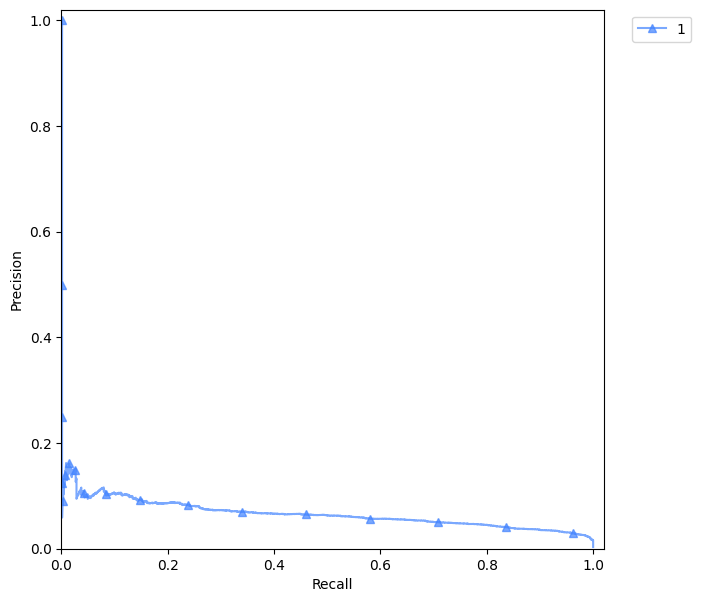

In [38]:
# precision-recall curves
%matplotlib inline
from animaloc.vizual import PlotPrecisionRecall
pr_curve = PlotPrecisionRecall(legend=True)
metrics = test_evaluator._stored_metrics
for c in range(1, metrics.num_classes):
    rec, pre = metrics.rec_pre_lists(c)
    pr_curve.feed(rec, pre, str(c))

pr_curve.plot()

In [61]:
# TEST config files
%%writefile /content/HerdNet/configs/test/myherdnet.yaml
wandb_project: 'HerdNet'
wandb_entity: 'ghazaleh-serati'
wandb_run: 'myrun'
device_name: 'cuda'

model:
  name: 'HerdNet'
  from_torchvision: False
  pth_file: '/content/drive/MyDrive/fine_tuned_base_herdnet.pth'
  kwargs:
    num_layers: 34
    pretrained: False
    down_ratio: 2
    head_conv: 64

dataset:
  img_size: [512,512]
  anno_type: 'point'
  num_classes: 1
  collate_fn: null

  class_def:
    1: 'caribou'


  name: 'CSVDataset'
  csv_file: '/content/test_patches/gt.csv'
  root_dir: '/content/test_patches'

  mean: [0.485, 0.456, 0.406]
  std: [0.229, 0.224, 0.225]

evaluator:
  name: 'HerdNetEvaluator'
  threshold: 5
  kwargs:
    lmds_kwargs:
      kernel_size: [3,3]
      adapt_ts: 0.3

stitcher:
  name: 'HerdNetStitcher'
  kwargs:
    overlap: 160
    down_ratio: ${test.model.kwargs.down_ratio}
    up: False
    reduction: 'mean'

Overwriting /content/HerdNet/configs/test/myherdnet.yaml


In [82]:
# Train config files
%%writefile /content/HerdNet/configs/train/myherdnet.yaml
wandb_project: 'HerdNet'
wandb_entity: 'ghazaleh-serati'
wandb_run: 'myrun'
seed: 1
device_name: 'cuda'

model:
  name: 'HerdNet'
  from_torchvision: False
  load_from: null
  resume_from: null
  kwargs:
    num_layers: 34
    pretrained: True
    down_ratio: 2
    head_conv: 64
  freeze: null


losses:
  FocalLoss:
    print_name: 'focal_loss'
    from_torch: False
    output_idx: 0
    target_idx: 0
    lambda_const: 1.0
    kwargs:
      reduction: 'mean'
      normalize: False
  CrossEntropyLoss:
    print_name: 'ce_loss'
    from_torch: True
    output_idx: 1
    target_idx: 1
    lambda_const: 1.0
    kwargs:
      reduction: 'mean'
      weight: [0.1,5.,15.,1.]

datasets:
  img_size: [512,512]
  anno_type: 'point'
  num_classes: 1
  collate_fn: null

  class_def:
    1: 'caribou'


  train:
    name: 'CSVDataset'
    csv_file: '/content/Train_patches/gt.csv'
    root_dir: '/content/Train_patches'

    sampler: null

    albu_transforms:
      HorizontalFlip:
        p: 0.5
      MotionBlur:
        p: 0.5
      Normalize:
        p: 1.0

    end_transforms:
      MultiTransformsWrapper:
        FIDT:
          num_classes: ${train.datasets.num_classes}
          down_ratio: ${train.model.kwargs.down_ratio}
        PointsToMask:
          radius: 2
          num_classes: ${train.datasets.num_classes}
          squeeze: True
          down_ratio: 32

  validate:
    name: 'CSVDataset'
    csv_file: '/content/val_patches/gt.csv'
    root_dir: '/content/val_patches'

    albu_transforms:
      Normalize:
        p: 1.0

    end_transforms:
      DownSample:
        down_ratio: ${train.model.kwargs.down_ratio}
        anno_type: ${train.datasets.anno_type}

training_settings:
  trainer: 'Trainer'
  valid_freq: 1
  print_freq: 100
  batch_size: 4
  optimizer: 'adam'
  lr: 1e-4
  weight_decay: 0.0005

  auto_lr:
    mode: 'max'
    patience: 10
    threshold: 1e-4
    threshold_mode: 'rel'
    cooldown: 10
    min_lr: 1e-6
    verbose: True
  warmup_iters: 100
  vizual_fn: null
  epochs: 1
  evaluator:
    name: 'HerdNetEvaluator'
    threshold: 5
    select_mode: 'max'
    validate_on: 'f1_score'
    kwargs:
      print_freq: 10
      lmds_kwargs:
        kernel_size: [3,3]
        adapt_ts: 0.3
  stitcher:
    name: 'HerdNetStitcher'
    kwargs:
      overlap: 0
      down_ratio: ${train.model.kwargs.down_ratio}
      up: False
      reduction: 'mean'

Overwriting /content/HerdNet/configs/train/myherdnet.yaml


In [85]:
# Launching training and testing sessions with config files
# !python /content/HerdNet/tools/train.py train=herdnet train.training_settings.batch_size=1,2,4 train.training_settings.lr=1e-3,1e-4
!python /content/HerdNet/tools/train.py -m train=myherdnet train.training_settings.batch_size=1,2,4 train.training_settings.lr=1e-3,1e-4, HYDRA_FULL_ERROR=1

/content/HerdNet/tools/train.py:222: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='../configs', config_name="config")
mismatched input '<EOF>' expecting {':', BRACKET_OPEN, BRACE_OPEN, FLOAT, INT, BOOL, NULL, UNQUOTED_CHAR, ID, ESC, WS, QUOTED_VALUE, INTERPOLATION}
See https://hydra.cc/docs/1.2/advanced/override_grammar/basic for details

Set the environment variable HYDRA_FULL_ERROR=1 for a complete stack trace.


In [43]:
!python /content/HerdNet/tools/test.py -m test=myherdnet

/content/HerdNet/tools/test.py:129: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='../configs', config_name="config")
[2023-11-07 22:29:10,616][HYDRA] Launching 1 jobs locally
[2023-11-07 22:29:10,616][HYDRA] 	#0 : test=myherdnet
/usr/local/lib/python3.10/dist-packages/hydra/_internal/core_plugins/basic_launcher.py:74: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  ret = run_job(
wandb: Currently logged in as: ghazaleh-serati. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /content/multirun/2023-11-07/22-29-10/0/wandb/run-20231107_222911-2tl6kief
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run dauntless-sa